In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
WORKDIR = "/content/drive/MyDrive/jigsaw/Jigsaw Puzzle Task/Jigsaw Results/"
import tensorflow as tf
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [ ]:
# tests help notebooks stay managable
import doctest
import copy
import functools

def autotest(func):
    globs = copy.copy(globals())
    globs.update({func.__name__: func})
    doctest.run_docstring_examples(
        func, globs, verbose=True, name=func.__name__)
    return func

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from skimage.io import imread as imread
from skimage.util import montage
montage_rgb = lambda x, **kwargs: np.stack([montage(x[..., i], **kwargs) for i in range(x.shape[-1])], -1)
from itertools import product
from tqdm import tqdm_notebook
from IPython.display import clear_output

In [ ]:
from tensorflow.keras.datasets import cifar10
train_ds, test_ds = cifar10.load_data()
X_train, y_train = train_ds
X_test, y_test = test_ds
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#X_train, y_train = X_train[0:20,:,:,:], y_train[0:20,:]
#X_test, y_test = X_test[0:20,:,:,:], y_test[0:20,:]


X_train = X_train/255.0
y_train = y_train[:, 0]
X_test = X_test/255.0
y_test = y_test[:, 0]
clear_output()
print(X_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


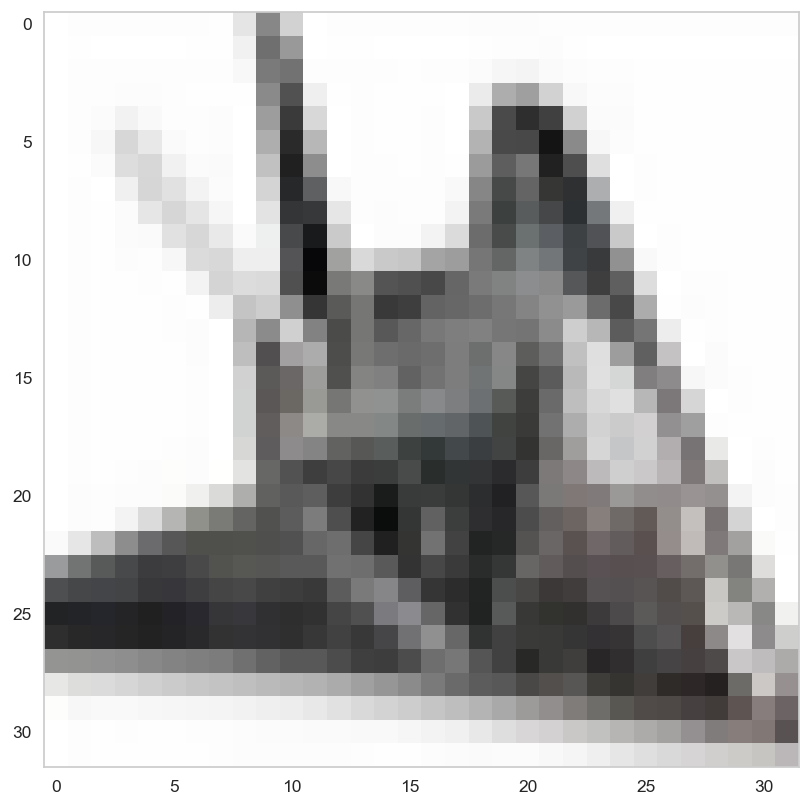

In [ ]:
img_idx = np.random.choice(range(X_train.shape[0]))
plt.imshow(X_train[img_idx])

In [ ]:
@autotest
def cut_jigsaw(
    in_image, # type: np.ndarray
    x_wid, # type: int
    y_wid,# type: int
    gap=False,
    jitter=False,
    jitter_dim=None, # type: Optional[int]
):
    # type: (...) -> List[np.ndarray]
    """Cuts the image into little pieces
    :param in_image: the image to cut-apart
    :param x_wid: the size of the piece in x
    :param y_wid: the size of the piece in y
    :param gap: if there is a gap between tiles
    :param jitter: if the positions should be moved around
    :param jitter_dim: amount to jitter (default is x_wid or y_wid/2)
    :return : a 4D array with tiles x x_wid x y_wid * d
    Examples
    >>> test_image = np.arange(20).reshape((4, 5)).astype(int)
    >>> test_image
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
    >>> cut_jigsaw(test_image, 2, 2, False, False)
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 2,  3],
            [ 7,  8]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[12, 13],
            [17, 18]]])
    >>> cut_jigsaw(test_image, 2, 2, True, False)
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 3,  4],
            [ 8,  9]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[13, 14],
            [18, 19]]])
    >>> np.random.seed(0)
    >>> cut_jigsaw(test_image, 2, 2, True, True, 1)
    array([[[ 1,  2],
            [ 6,  7]],
    <BLANKLINE>
           [[ 7,  8],
            [12, 13]],
    <BLANKLINE>
           [[ 5,  6],
            [10, 11]],
    <BLANKLINE>
           [[ 7,  8],
            [12, 13]]])
    """
    if len(in_image.shape)==2:
        in_image = np.expand_dims(in_image, -1)
        expand = True
    else:
        expand = False
    x_size, y_size, d_size = in_image.shape
    out_tiles = []
    x_chunks = x_size//x_wid
    y_chunks = y_size//y_wid
    out_tiles = np.zeros((x_chunks*y_chunks, x_wid, y_wid, d_size), dtype=in_image.dtype)
    if gap:
        # we calculate the maximum gap and 
        x_gap = x_size-x_chunks*x_wid
        y_gap = y_size-y_chunks*y_wid
    else:
        x_gap, y_gap = 0, 0
    x_jitter = x_wid//2 if jitter_dim is None else jitter_dim
    y_jitter = y_wid//2 if jitter_dim is None else jitter_dim
    for idx, (i, j) in enumerate(product(range(x_chunks), range(y_chunks))):
        x_start = i*x_wid+min(x_gap, i)
        y_start = j*y_wid+min(y_gap, j)
        if jitter:
            x_range = max(x_start-x_jitter, 0), min(x_start+x_jitter+1, x_size-x_wid)
            y_range = max(y_start-y_jitter, 0), min(y_start+y_jitter+1, y_size-y_wid)
            
            x_start = np.random.choice(range(*x_range)) if x_range[1]>x_range[0] else x_start
            y_start = np.random.choice(range(*y_range)) if y_range[1]>y_range[0] else y_start
            
        out_tiles[idx, :, :, :] = in_image[x_start:x_start+x_wid, y_start:y_start+y_wid, :]
    
    return out_tiles[:, :, :, 0] if expand else out_tiles
                

Finding tests in cut_jigsaw
Trying:
    test_image = np.arange(20).reshape((4, 5)).astype(int)
Expecting nothing
ok
Trying:
    test_image
Expecting:
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
ok
Trying:
    cut_jigsaw(test_image, 2, 2, False, False)
Expecting:
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 2,  3],
            [ 7,  8]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[12, 13],
            [17, 18]]])
ok
Trying:
    cut_jigsaw(test_image, 2, 2, True, False)
Expecting:
    array([[[ 0,  1],
            [ 5,  6]],
    <BLANKLINE>
           [[ 3,  4],
            [ 8,  9]],
    <BLANKLINE>
           [[10, 11],
            [15, 16]],
    <BLANKLINE>
           [[13, 14],
            [18, 19]]])
ok
Trying:
    np.random.seed(0)
Expecting nothing
ok
Trying:
    cut_jigsaw(test_image, 2, 2, True, True, 1)
Expecting:
 

In [ ]:
@autotest
def jigsaw_to_image(
    in_tiles, # type: np.ndarray
    out_x, # type: int
    out_y, # type: int
    gap=False
):
    # type: (...) -> np.ndarray
    """Reassembles little pieces into an image
    :param in_tiles: the tiles to reassemble
    :param out_x: the size of the image in x (default is calculated automatically)
    :param out_y: the size of the image in y
    :param gap: if there is a gap between tiles
    :return : an image from the tiles
    Examples
    >>> test_image = np.arange(20).reshape((4, 5)).astype(int)
    >>> test_image
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
    >>> js_pieces = cut_jigsaw(test_image, 2, 2, False, False)
    >>> jigsaw_to_image(js_pieces, 4, 5)
    array([[ 0,  1,  2,  3,  0],
           [ 5,  6,  7,  8,  0],
           [10, 11, 12, 13,  0],
           [15, 16, 17, 18,  0]])
    >>> js_gap_pieces = cut_jigsaw(test_image, 2, 2, True, False)
    >>> jigsaw_to_image(js_gap_pieces, 4, 5, True)
    array([[ 0,  1,  0,  3,  4],
           [ 5,  6,  0,  8,  9],
           [10, 11,  0, 13, 14],
           [15, 16,  0, 18, 19]])
    >>> np.random.seed(0)
    >>> js_gap_pieces = cut_jigsaw(test_image, 2, 2, False, True)
    >>> jigsaw_to_image(js_gap_pieces, 4, 5, False)
    array([[ 1,  2,  6,  7,  0],
           [ 6,  7, 11, 12,  0],
           [ 6,  7,  7,  8,  0],
           [11, 12, 12, 13,  0]])
    """
    if len(in_tiles.shape)==3:
        in_tiles = np.expand_dims(in_tiles, -1)
        expand = True
    else:
        expand = False
    tile_count, x_wid, y_wid, d_size = in_tiles.shape
    x_chunks = out_x//x_wid
    y_chunks = out_y//y_wid
    out_image = np.zeros((out_x, out_y, d_size), dtype=in_tiles.dtype)
    
    if gap:
        x_gap = out_x-x_chunks*x_wid
        y_gap = out_y-y_chunks*y_wid
    else:
        x_gap, y_gap = 0, 0
        
    for idx, (i, j) in enumerate(product(range(x_chunks), range(y_chunks))):
        x_start = i*x_wid+min(x_gap, i)
        y_start = j*y_wid+min(y_gap, j)
        out_image[x_start:x_start+x_wid, y_start:y_start+y_wid] = in_tiles[idx, :, :]
    
    return out_image[:, :, 0] if expand else out_image
    
    
    

Finding tests in jigsaw_to_image
Trying:
    test_image = np.arange(20).reshape((4, 5)).astype(int)
Expecting nothing
ok
Trying:
    test_image
Expecting:
    array([[ 0,  1,  2,  3,  4],
           [ 5,  6,  7,  8,  9],
           [10, 11, 12, 13, 14],
           [15, 16, 17, 18, 19]])
ok
Trying:
    js_pieces = cut_jigsaw(test_image, 2, 2, False, False)
Expecting nothing
ok
Trying:
    jigsaw_to_image(js_pieces, 4, 5)
Expecting:
    array([[ 0,  1,  2,  3,  0],
           [ 5,  6,  7,  8,  0],
           [10, 11, 12, 13,  0],
           [15, 16, 17, 18,  0]])
ok
Trying:
    js_gap_pieces = cut_jigsaw(test_image, 2, 2, True, False)
Expecting nothing
ok
Trying:
    jigsaw_to_image(js_gap_pieces, 4, 5, True)
Expecting:
    array([[ 0,  1,  0,  3,  4],
           [ 5,  6,  0,  8,  9],
           [10, 11,  0, 13, 14],
           [15, 16,  0, 18, 19]])
ok
Trying:
    np.random.seed(0)
Expecting nothing
ok
Trying:
    js_gap_pieces = cut_jigsaw(test_image, 2, 2, False, True)
Expecting nothi

In [ ]:
TILE_X = 10
TILE_Y = 10
JITTER_SIZE = 3
TRAIN_TILE_COUNT = 2**15
VALID_TILE_COUNT = 2**11
KEEP_RANDOM_PERM = 200
LATENT_SIZE = 16
BIG_LATENT_SIZE = 64
RECON_LATENT_SHAPE = (8, 8, 8)

In [ ]:
X_train.shape[1], X_train.shape[2]

(32, 32)

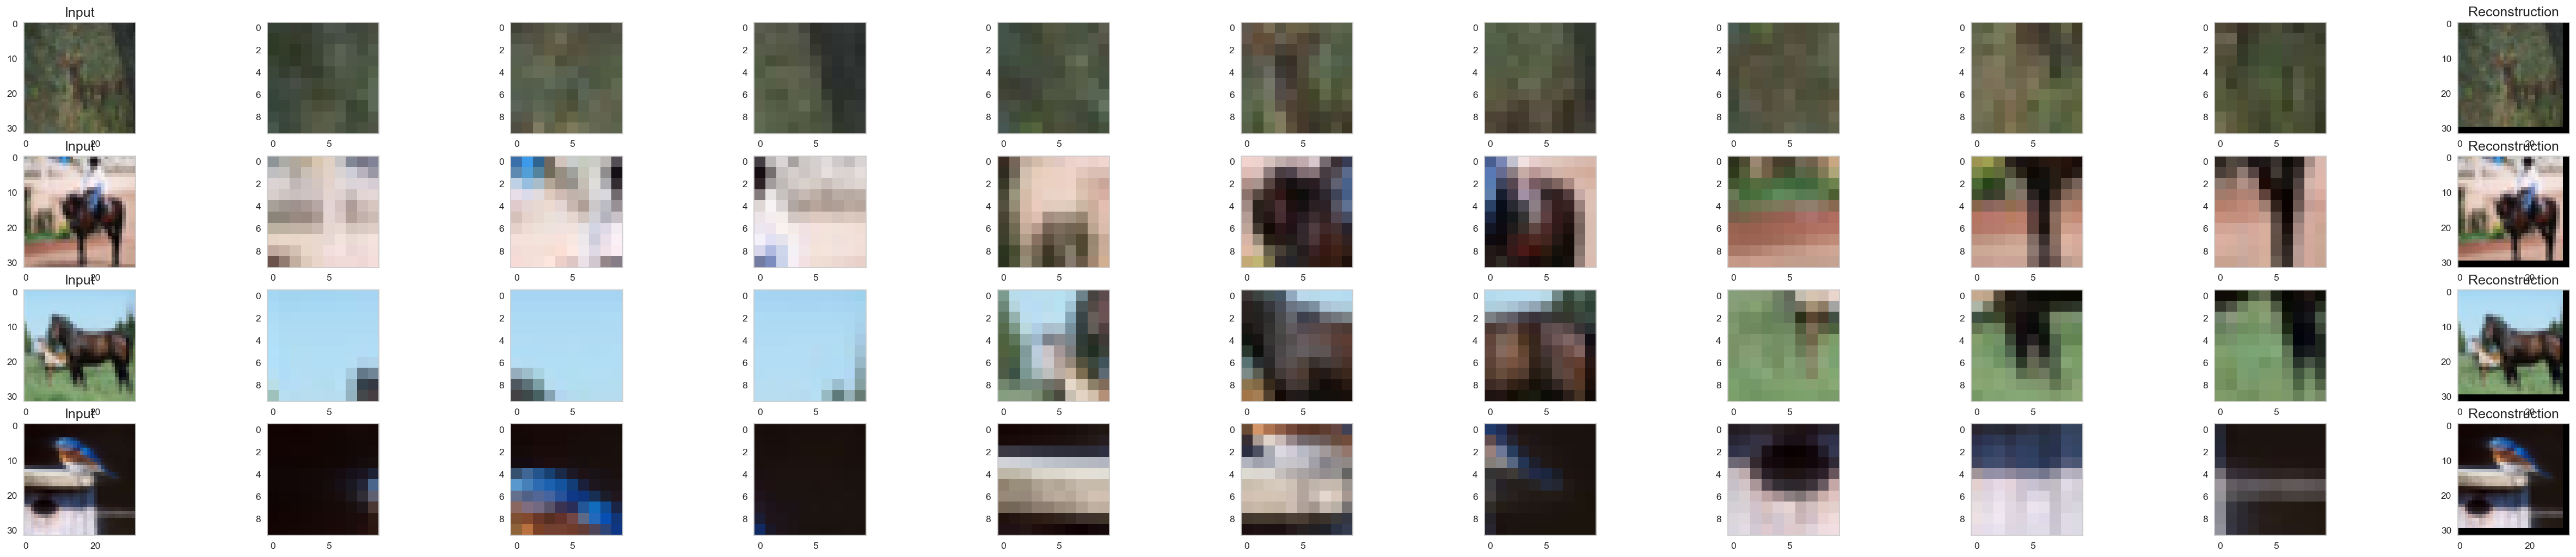

In [ ]:
fig, m_axs = plt.subplots(4, 11, figsize=(50, 10))
for img_idx, c_axs in enumerate(m_axs, 10):
    c_axs[0].imshow(X_train[img_idx, :, :])
    c_axs[0].set_title('Input')
    out_tiles = cut_jigsaw(X_train[img_idx, :, :], TILE_X, TILE_Y, gap=False) 
    for k, c_ax in zip(range(out_tiles.shape[0]), c_axs[1:]):
        c_ax.imshow(out_tiles[k, :, :])
    recon_img = jigsaw_to_image(out_tiles, X_train.shape[1], X_train.shape[2])
    c_axs[-1].imshow(recon_img[:, :])
    c_axs[-1].set_title('Reconstruction')

In [ ]:
from itertools import permutations
all_perm = np.array(list(permutations(range(out_tiles.shape[0]), out_tiles.shape[0])))
print('Permutation count:' , len(all_perm))

np.random.seed(2019)
# first one is always unmessed up
keep_perm = all_perm[0:1, :].tolist()+all_perm[np.random.choice(range(1, len(all_perm)), KEEP_RANDOM_PERM-1), :].tolist()

Permutation count: 362880


### Show combinations
Here we can show combinations along with various instances of jitter noise to see how much that affects the reconstruction

0 [0, 1, 2, 3, 4, 5, 6, 7, 8]
1 [4, 1, 8, 5, 6, 2, 3, 7, 0]
2 [1, 5, 0, 2, 8, 3, 4, 6, 7]
3 [0, 3, 4, 7, 5, 8, 6, 1, 2]
4 [7, 2, 4, 1, 0, 6, 8, 5, 3]
0 [0, 1, 2, 3, 4, 5, 6, 7, 8]
1 [4, 1, 8, 5, 6, 2, 3, 7, 0]
2 [1, 5, 0, 2, 8, 3, 4, 6, 7]
3 [0, 3, 4, 7, 5, 8, 6, 1, 2]
4 [7, 2, 4, 1, 0, 6, 8, 5, 3]
0 [0, 1, 2, 3, 4, 5, 6, 7, 8]
1 [4, 1, 8, 5, 6, 2, 3, 7, 0]
2 [1, 5, 0, 2, 8, 3, 4, 6, 7]
3 [0, 3, 4, 7, 5, 8, 6, 1, 2]
4 [7, 2, 4, 1, 0, 6, 8, 5, 3]
0 [0, 1, 2, 3, 4, 5, 6, 7, 8]
1 [4, 1, 8, 5, 6, 2, 3, 7, 0]
2 [1, 5, 0, 2, 8, 3, 4, 6, 7]
3 [0, 3, 4, 7, 5, 8, 6, 1, 2]
4 [7, 2, 4, 1, 0, 6, 8, 5, 3]
0 [0, 1, 2, 3, 4, 5, 6, 7, 8]
1 [4, 1, 8, 5, 6, 2, 3, 7, 0]
2 [1, 5, 0, 2, 8, 3, 4, 6, 7]
3 [0, 3, 4, 7, 5, 8, 6, 1, 2]
4 [7, 2, 4, 1, 0, 6, 8, 5, 3]


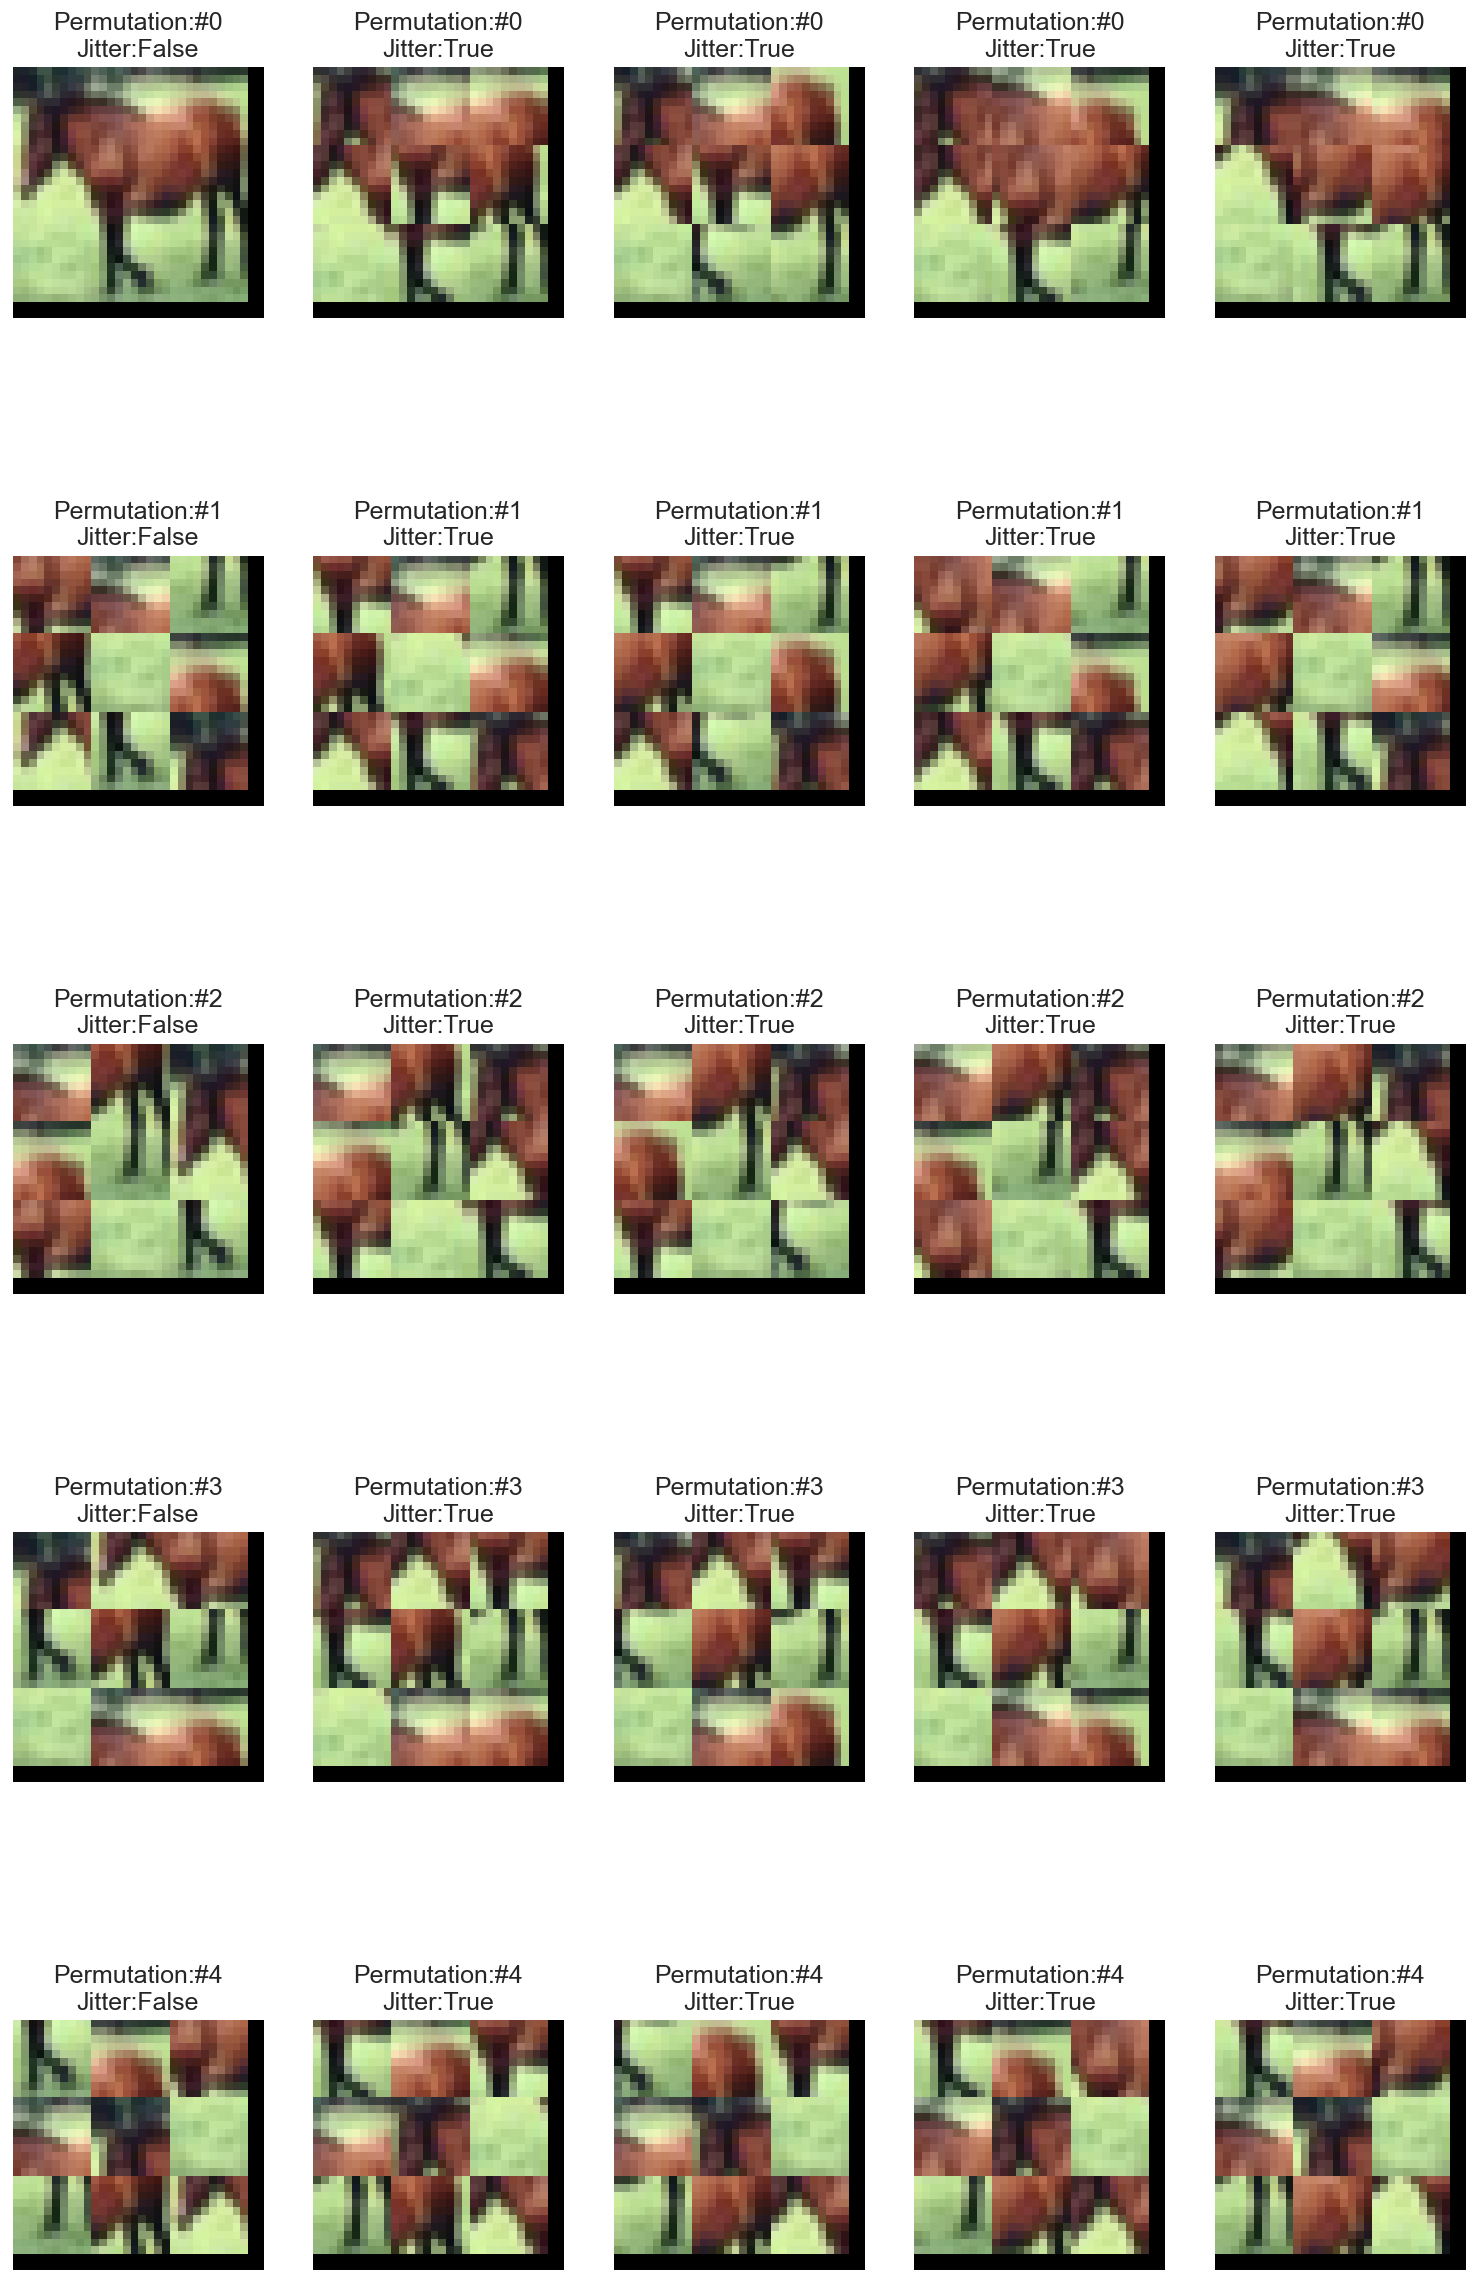

In [ ]:
fig, m_axs = plt.subplots(5, 5, figsize=(15, 25))
for i, c_axs in enumerate(m_axs.T):
    out_tiles = cut_jigsaw(X_train[7], TILE_X, TILE_Y, gap=False, jitter=i>0, jitter_dim=JITTER_SIZE) 
    for j, (c_ax, c_perm) in enumerate(zip(c_axs, keep_perm)): 
        print(j,c_perm)
        scrambled_tiles = out_tiles[c_perm]
        recon_img = jigsaw_to_image(scrambled_tiles, X_train.shape[1], X_train.shape[2])
        c_ax.imshow(recon_img)
        c_ax.set_title('Permutation:#{}\nJitter:{}'.format(j, i>0))
        c_ax.axis('off')

# Data Preparation
In order to train a model we need to pre-compute a whole bunch of data to train models with

In [ ]:
TRAIN_TILE_COUNT

32768

In [ ]:
out_tiles = cut_jigsaw(X_train[8, :, :], TILE_X, TILE_Y, gap=False) 
print(out_tiles.shape)
def _generate_batch(in_idx, is_valid=False):
    np.random.seed(in_idx)
    if is_valid:
        img_ds = X_test
    else:
        img_ds = X_train
    img_idx = np.random.choice(range(img_ds.shape[0]))
    out_tiles = cut_jigsaw(img_ds[img_idx, :, :], TILE_X, TILE_Y, gap=True, jitter=JITTER_SIZE>0, jitter_dim=JITTER_SIZE) 
    perm_idx = np.random.choice(range(len(keep_perm)))
    c_perm = keep_perm[perm_idx]
    return out_tiles[c_perm], perm_idx, img_ds[img_idx, :, :]

def make_tile_group(tile_count, is_valid=False):
    c_tiles = np.zeros((tile_count,)+out_tiles.shape, dtype='float32')
    c_perms = np.zeros((tile_count,), dtype='int')
    c_recon_image = np.zeros((tile_count,)+X_train.shape[1:], dtype='float32')
    for i in tqdm_notebook(range(tile_count)):
        # should be parallelized
        c_tiles[i], c_perms[i], c_recon_image[i] = _generate_batch(i, is_valid=is_valid)
    return c_tiles, c_perms, c_recon_image
train_tiles, train_perms, train_recons = make_tile_group(TRAIN_TILE_COUNT)
valid_tiles, valid_perms, valid_recons = make_tile_group(VALID_TILE_COUNT, is_valid=True)

(9, 10, 10, 3)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/32768 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

In [ ]:
train_perms[0:10]

array([ 88, 146,   4, 172, 126,  27, 161,   6, 137, 128])

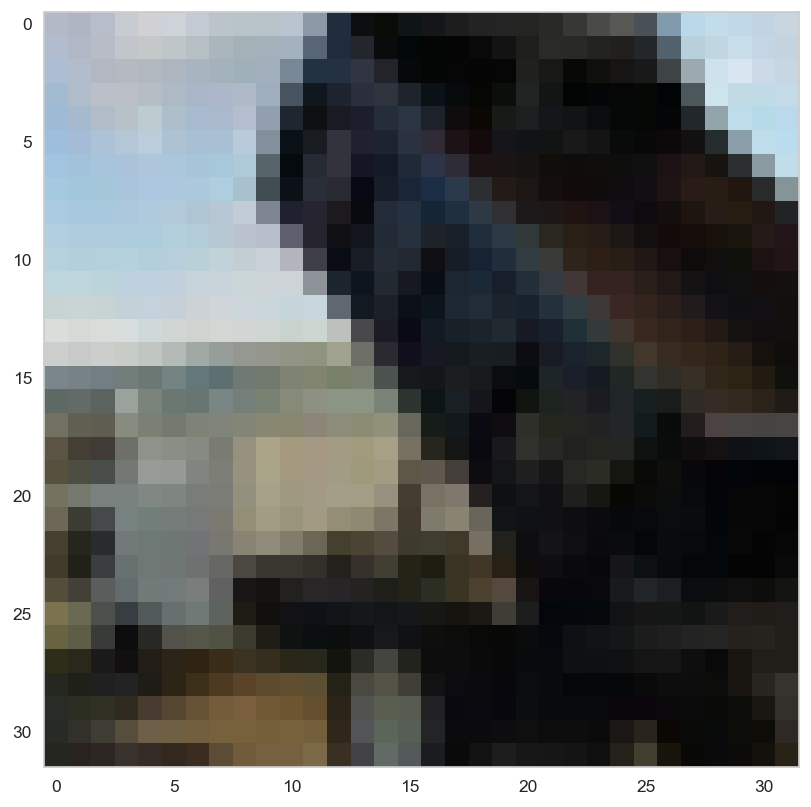

In [ ]:
plt.imshow(train_recons[2])

In [ ]:
import winsound
winsound.Beep(2000,2000)

# Model Building
## Encoder Model


In [ ]:
from tensorflow.keras import models, layers
tile_encoder = models.Sequential(name='TileEncoder')
# we use None to make the model more usuable later
tile_encoder.add(layers.BatchNormalization(input_shape=(None,None)+(train_tiles.shape[-1],)))
tile_encoder.add(layers.Conv2D(8, (3,3), padding='same', activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.MaxPool2D(2,2))
tile_encoder.add(layers.LeakyReLU(0.1))
tile_encoder.add(layers.Conv2D(16, (3,3), padding='same', activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.MaxPool2D(2,2))
tile_encoder.add(layers.LeakyReLU(0.1))
tile_encoder.add(layers.Conv2D(32, (2,2), padding='valid', activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.LeakyReLU(0.1))
tile_encoder.add(layers.Conv2D(LATENT_SIZE, (1,1), activation='linear'))
tile_encoder.add(layers.BatchNormalization())
tile_encoder.add(layers.LeakyReLU(0.1))
clear_output() # some annoying loading/warnings come up

In [ ]:
tile_encoder.summary()

Model: "TileEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, None, None, 3)     12        
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 8)     224       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 8)     32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 8)     0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, None, None, 8)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 16)    

In [ ]:
print('Model Input Shape:', train_tiles.shape[2:], 
      '-> Model Output Shape:', tile_encoder.predict(np.zeros((1,)+train_tiles.shape[2:])).shape[1:])

Model Input Shape: (10, 10, 3) -> Model Output Shape: (1, 1, 16)


## Big Jigsaw Permutation Model (Decoder Part)


In [ ]:
big_in = layers.Input(train_tiles.shape[1:], name='All_Tile_Input')
feat_vec = []
for k in range(train_tiles.shape[1]):
    lay_x = layers.Lambda(lambda x: x[:, k], name='Select_{}_Tile'.format(k))(big_in)
    feat_x = tile_encoder(lay_x)
    feat_vec += [layers.GlobalAvgPool2D()(feat_x)]
feat_cat = layers.concatenate(feat_vec)
feat_dr = layers.Dropout(0.5)(feat_cat)
# learn the scrambling permutation
feat_latent = layers.Dense(BIG_LATENT_SIZE)(feat_dr)
feat_latent_dr = layers.Dropout(0.5)(feat_latent)
out_pred = layers.Dense(KEEP_RANDOM_PERM, activation='softmax', name='PermutationCategory')(feat_latent_dr)
# learn the image
# here we try to reconstruct the original image from the scrambled tiles (so to learn the re-ordering and the combination together)
recon_latent = layers.Dense(np.prod(RECON_LATENT_SHAPE).astype(int))(feat_dr)
recon_image = layers.Reshape(RECON_LATENT_SHAPE)(recon_latent)
recon_image = layers.Conv2D(RECON_LATENT_SHAPE[2], (3,3), padding='same', activation='linear')(recon_image)
up_steps = np.log2(X_train.shape[1]/RECON_LATENT_SHAPE[0]).astype(int)
for i in range(up_steps):
    recon_image = layers.UpSampling2D((2, 2))(recon_image)
    recon_image = layers.Conv2D(RECON_LATENT_SHAPE[-1]//2**(i+1), (3,3), padding='same', activation='linear')(recon_image)
    recon_image = layers.BatchNormalization()(recon_image)
    recon_image = layers.LeakyReLU(0.1)(recon_image)
    
recon_image = layers.Conv2D(train_tiles.shape[-1], (1,1), padding='same', activation='sigmoid', name='ReconImage')(recon_image)
big_model = models.Model(inputs=big_in, outputs= recon_image)
big_model.compile(optimizer='adam', 
                  loss={'ReconImage': 'mse'}, 
                  metrics={
                    'ReconImage': ['mae', 'binary_accuracy']}
                 )




In [ ]:
big_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
All_Tile_Input (InputLayer)     [(None, 9, 10, 10, 3 0                                            
__________________________________________________________________________________________________
Select_0_Tile (Lambda)          (None, 10, 10, 3)    0           All_Tile_Input[0][0]             
__________________________________________________________________________________________________
Select_1_Tile (Lambda)          (None, 10, 10, 3)    0           All_Tile_Input[0][0]             
__________________________________________________________________________________________________
Select_2_Tile (Lambda)          (None, 10, 10, 3)    0           All_Tile_Input[0][0]             
_______________________________________________________________________________________

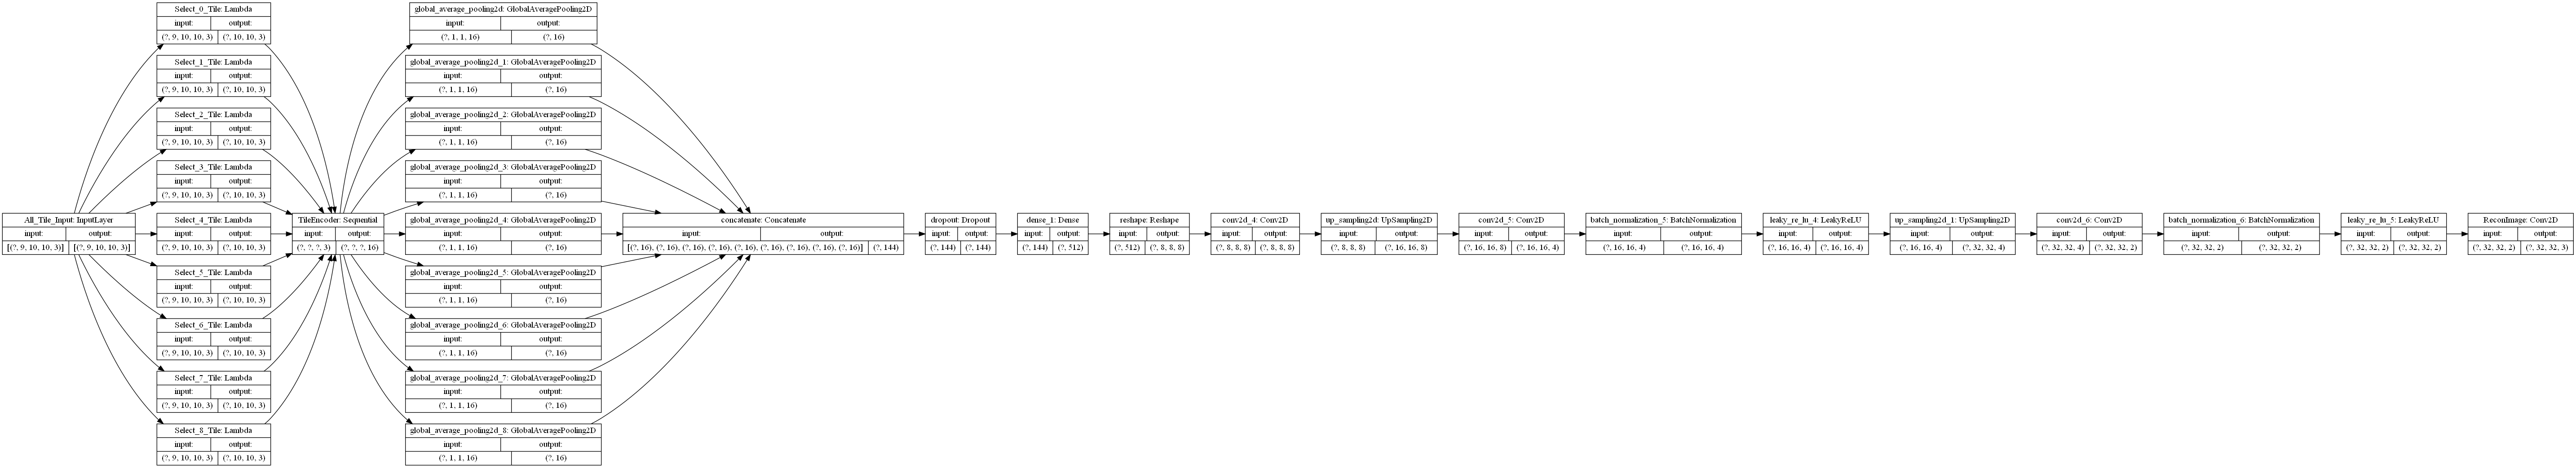

In [ ]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image
dot_model = model_to_dot(big_model, show_shapes=True)
dot_model.set_rankdir('LR')
Image(dot_model.create_png())

In [ ]:
reversed_keep_perm = [[c_dict[j] for j in range(out_tiles.shape[0])]
                      for c_dict in [{j: i for i, j in enumerate(c_perm)}
                                     for c_perm in keep_perm]]
for i in range(3):
    print('forward', keep_perm[i], 'reversed', reversed_keep_perm[i])

forward [0, 1, 2, 3, 4, 5, 6, 7, 8] reversed [0, 1, 2, 3, 4, 5, 6, 7, 8]
forward [4, 1, 8, 5, 6, 2, 3, 7, 0] reversed [8, 1, 5, 6, 0, 3, 4, 7, 2]
forward [1, 5, 0, 2, 8, 3, 4, 6, 7] reversed [2, 0, 3, 5, 6, 1, 7, 8, 4]


(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]


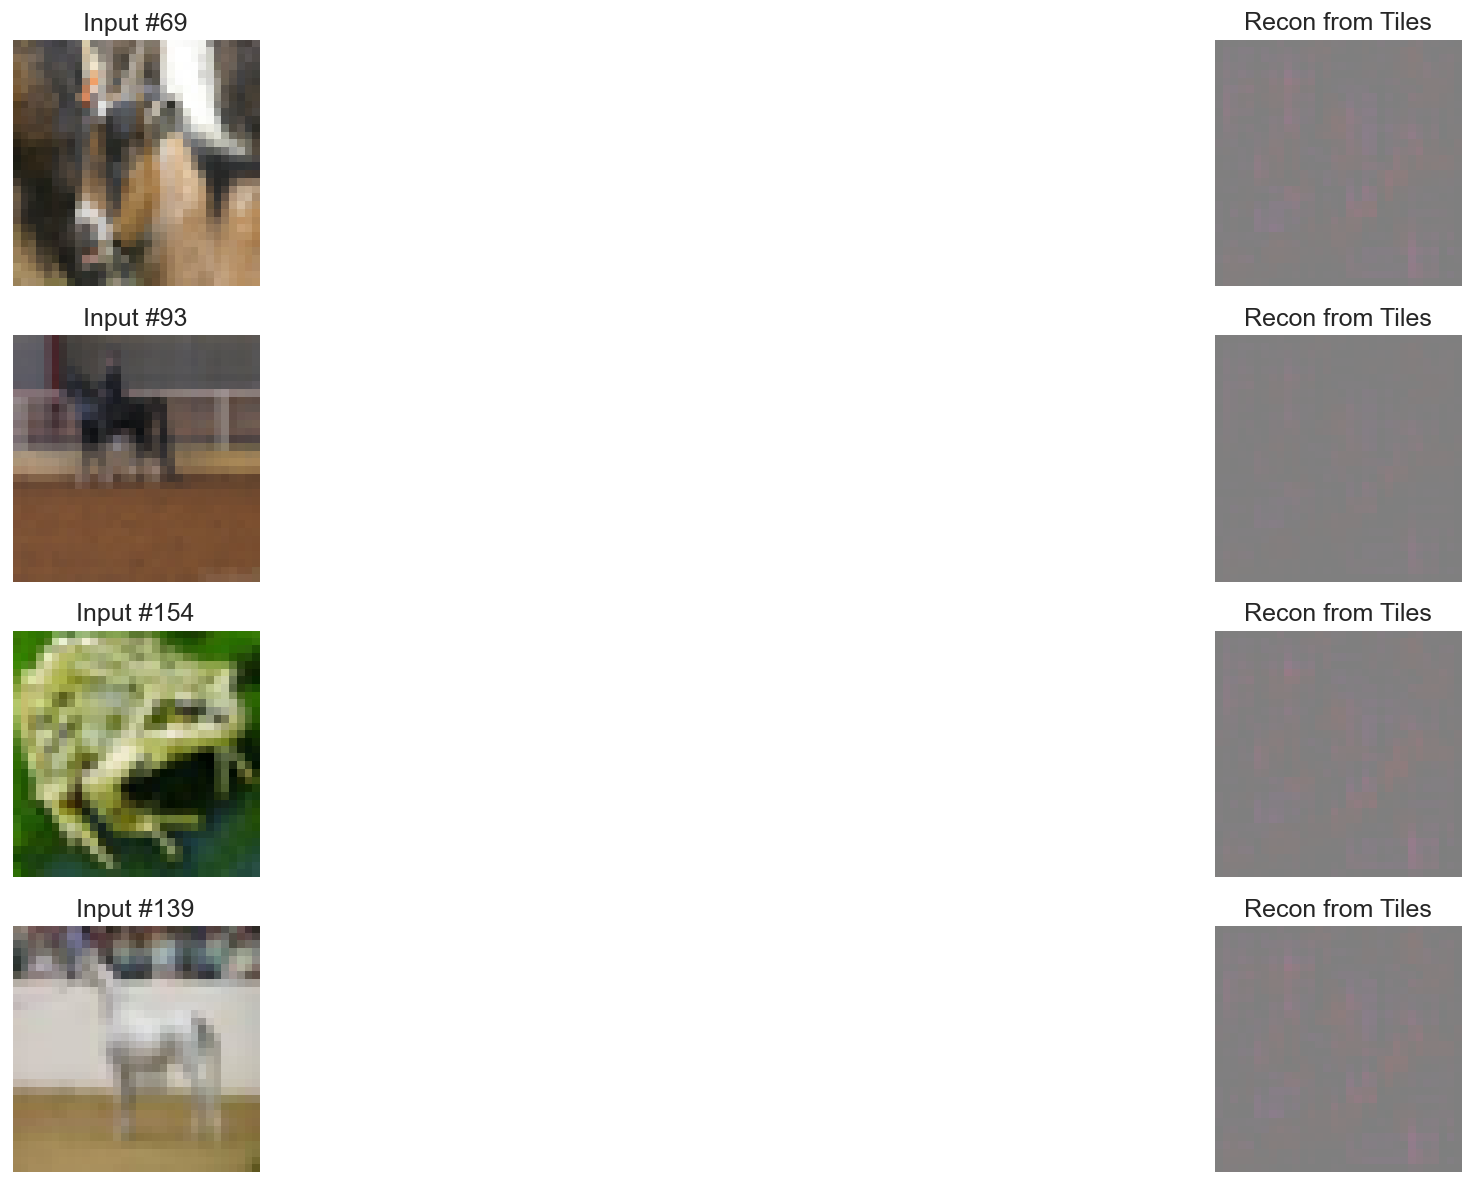

In [ ]:
def show_model_output(image_count=4, perm_count=3): 
    fig, m_axs = plt.subplots(image_count, perm_count+2, figsize=(3*(perm_count+2), 3*image_count))
    [c_ax.axis('off') for c_ax in m_axs.flatten()]
    for img_idx, c_axs in enumerate(m_axs):
        img_idx = np.random.choice(range(X_train.shape[0]))
        perm_idx = np.random.choice(range(len(keep_perm)))
        c_axs[0].imshow(X_train[img_idx])
        
        c_axs[0].set_title('Input #{}'.format(perm_idx))
        # generate tiles
        out_tiles = cut_jigsaw(X_train[img_idx, :, :], TILE_X, TILE_Y, gap=True, jitter=JITTER_SIZE>0, jitter_dim=JITTER_SIZE)
        # scramble tiles
        print(out_tiles.shape)
        c_perm = keep_perm[perm_idx]
        scr_tiles = out_tiles[c_perm]
        print(scr_tiles.shape)
        print(np.expand_dims(scr_tiles,0).shape)
        print(big_model.inputs)
        # get model prediction
        #out_pred, 
        out_recon = big_model.predict(np.expand_dims(scr_tiles,0))
        #out_pred = out_pred[0]
        
#         for c_ax, k_idx in zip(c_axs[1:-1], np.argsort(-1*out_pred)):
#             pred_rev_perm = reversed_keep_perm[k_idx]
#             recon_img = jigsaw_to_image(scr_tiles[pred_rev_perm], X_train.shape[1], X_train.shape[2])
#             c_ax.imshow(recon_img)
#             c_ax.set_title('Pred: #{} ({:2.2%})'.format(k_idx, out_pred[k_idx]))
        
        c_axs[-1].imshow(out_recon[0])
        c_axs[-1].set_title('Recon from Tiles')
show_model_output()

In [ ]:
train_tiles.shape,train_recons.shape,out_tiles.shape

((32768, 9, 10, 10, 3), (32768, 32, 32, 3), (9, 10, 10, 3))

In [ ]:
y_pred=big_model(np.expand_dims(train_tiles[0],axis=0))
train_tiles[0].shape,train_recons[0].shape,y_pred.shape

((9, 10, 10, 3), (32, 32, 3), TensorShape([1, 32, 32, 3]))

In [ ]:
fit_results = big_model.fit(train_tiles,train_recons, 
                            validation_data=(valid_tiles, valid_recons),
                                 batch_size=512,
                                 epochs=1000)

Epoch 1/1000
64/64 [==============================] - 4s 62ms/step - loss: 0.0666 - mae: 0.2129 - binary_accuracy: 0.0062 - val_loss: 0.0632 - val_mae: 0.2068 - val_binary_accuracy: 0.0069
Epoch 2/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0610 - mae: 0.2047 - binary_accuracy: 0.0062 - val_loss: 0.0600 - val_mae: 0.2022 - val_binary_accuracy: 0.0076
Epoch 3/1000
64/64 [==============================] - 3s 47ms/step - loss: 0.0591 - mae: 0.2012 - binary_accuracy: 0.0072 - val_loss: 0.0579 - val_mae: 0.1985 - val_binary_accuracy: 0.0089
Epoch 4/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0573 - mae: 0.1977 - binary_accuracy: 0.0084 - val_loss: 0.0560 - val_mae: 0.1946 - val_binary_accuracy: 0.0098
Epoch 5/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0556 - mae: 0.1941 - binary_accuracy: 0.0090 - val_loss: 0.0544 - val_mae: 0.1916 - val_binary_accuracy: 0.0105
Epoch 6/1000
64/64 [==============================] - 3

64/64 [==============================] - 3s 44ms/step - loss: 0.0489 - mae: 0.1775 - binary_accuracy: 0.0100 - val_loss: 0.0498 - val_mae: 0.1787 - val_binary_accuracy: 0.0110
Epoch 45/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0489 - mae: 0.1775 - binary_accuracy: 0.0100 - val_loss: 0.0500 - val_mae: 0.1792 - val_binary_accuracy: 0.0109
Epoch 46/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0489 - mae: 0.1774 - binary_accuracy: 0.0100 - val_loss: 0.0499 - val_mae: 0.1791 - val_binary_accuracy: 0.0108
Epoch 47/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0488 - mae: 0.1773 - binary_accuracy: 0.0100 - val_loss: 0.0498 - val_mae: 0.1779 - val_binary_accuracy: 0.0111
Epoch 48/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0488 - mae: 0.1773 - binary_accuracy: 0.0100 - val_loss: 0.0499 - val_mae: 0.1790 - val_binary_accuracy: 0.0110
Epoch 49/1000
64/64 [==============================] - 3s 45ms/s

64/64 [==============================] - 3s 45ms/step - loss: 0.0483 - mae: 0.1762 - binary_accuracy: 0.0101 - val_loss: 0.0502 - val_mae: 0.1781 - val_binary_accuracy: 0.0112
Epoch 88/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0483 - mae: 0.1762 - binary_accuracy: 0.0101 - val_loss: 0.0501 - val_mae: 0.1782 - val_binary_accuracy: 0.0112
Epoch 89/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0483 - mae: 0.1761 - binary_accuracy: 0.0101 - val_loss: 0.0500 - val_mae: 0.1785 - val_binary_accuracy: 0.0113
Epoch 90/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0483 - mae: 0.1762 - binary_accuracy: 0.0101 - val_loss: 0.0500 - val_mae: 0.1789 - val_binary_accuracy: 0.0112
Epoch 91/1000
64/64 [==============================] - 3s 47ms/step - loss: 0.0483 - mae: 0.1761 - binary_accuracy: 0.0101 - val_loss: 0.0499 - val_mae: 0.1784 - val_binary_accuracy: 0.0110
Epoch 92/1000
64/64 [==============================] - 3s 53ms/s

64/64 [==============================] - 3s 44ms/step - loss: 0.0480 - mae: 0.1756 - binary_accuracy: 0.0101 - val_loss: 0.0500 - val_mae: 0.1796 - val_binary_accuracy: 0.0112
Epoch 131/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0480 - mae: 0.1755 - binary_accuracy: 0.0101 - val_loss: 0.0502 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 132/1000
64/64 [==============================] - 3s 43ms/step - loss: 0.0480 - mae: 0.1755 - binary_accuracy: 0.0101 - val_loss: 0.0500 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 133/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0481 - mae: 0.1757 - binary_accuracy: 0.0101 - val_loss: 0.0499 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 134/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0480 - mae: 0.1755 - binary_accuracy: 0.0101 - val_loss: 0.0501 - val_mae: 0.1784 - val_binary_accuracy: 0.0111
Epoch 135/1000
64/64 [==============================] - 3s 4

Epoch 173/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0478 - mae: 0.1752 - binary_accuracy: 0.0102 - val_loss: 0.0502 - val_mae: 0.1787 - val_binary_accuracy: 0.0112
Epoch 174/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0478 - mae: 0.1751 - binary_accuracy: 0.0102 - val_loss: 0.0501 - val_mae: 0.1787 - val_binary_accuracy: 0.0112
Epoch 175/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0478 - mae: 0.1752 - binary_accuracy: 0.0102 - val_loss: 0.0501 - val_mae: 0.1785 - val_binary_accuracy: 0.0112
Epoch 176/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0478 - mae: 0.1752 - binary_accuracy: 0.0102 - val_loss: 0.0501 - val_mae: 0.1790 - val_binary_accuracy: 0.0110
Epoch 177/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0478 - mae: 0.1750 - binary_accuracy: 0.0102 - val_loss: 0.0500 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 178/1000
64/64 [=======================

Epoch 216/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0477 - mae: 0.1749 - binary_accuracy: 0.0102 - val_loss: 0.0502 - val_mae: 0.1778 - val_binary_accuracy: 0.0112
Epoch 217/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0477 - mae: 0.1749 - binary_accuracy: 0.0102 - val_loss: 0.0501 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 218/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0477 - mae: 0.1750 - binary_accuracy: 0.0102 - val_loss: 0.0501 - val_mae: 0.1790 - val_binary_accuracy: 0.0112
Epoch 219/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0476 - mae: 0.1748 - binary_accuracy: 0.0102 - val_loss: 0.0502 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 220/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0477 - mae: 0.1749 - binary_accuracy: 0.0102 - val_loss: 0.0500 - val_mae: 0.1784 - val_binary_accuracy: 0.0111
Epoch 221/1000
64/64 [=======================

Epoch 259/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0476 - mae: 0.1746 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1785 - val_binary_accuracy: 0.0112
Epoch 260/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0476 - mae: 0.1747 - binary_accuracy: 0.0102 - val_loss: 0.0502 - val_mae: 0.1782 - val_binary_accuracy: 0.0112
Epoch 261/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0476 - mae: 0.1747 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1789 - val_binary_accuracy: 0.0111
Epoch 262/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0476 - mae: 0.1746 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1789 - val_binary_accuracy: 0.0111
Epoch 263/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0475 - mae: 0.1745 - binary_accuracy: 0.0103 - val_loss: 0.0501 - val_mae: 0.1786 - val_binary_accuracy: 0.0110
Epoch 264/1000
64/64 [=======================

Epoch 302/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0475 - mae: 0.1744 - binary_accuracy: 0.0102 - val_loss: 0.0503 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 303/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0475 - mae: 0.1745 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1785 - val_binary_accuracy: 0.0110
Epoch 304/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0475 - mae: 0.1744 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1781 - val_binary_accuracy: 0.0111
Epoch 305/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0475 - mae: 0.1744 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1783 - val_binary_accuracy: 0.0112
Epoch 306/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0475 - mae: 0.1745 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1781 - val_binary_accuracy: 0.0111
Epoch 307/1000
64/64 [=======================

Epoch 345/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0474 - mae: 0.1743 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 346/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0474 - mae: 0.1743 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 347/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0475 - mae: 0.1744 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1791 - val_binary_accuracy: 0.0110
Epoch 348/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0474 - mae: 0.1743 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1784 - val_binary_accuracy: 0.0110
Epoch 349/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0474 - mae: 0.1743 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1782 - val_binary_accuracy: 0.0111
Epoch 350/1000
64/64 [=======================

Epoch 388/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0474 - mae: 0.1743 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1779 - val_binary_accuracy: 0.0113
Epoch 389/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0474 - mae: 0.1743 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1783 - val_binary_accuracy: 0.0112
Epoch 390/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0474 - mae: 0.1742 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1789 - val_binary_accuracy: 0.0110
Epoch 391/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0474 - mae: 0.1742 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1778 - val_binary_accuracy: 0.0111
Epoch 392/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0474 - mae: 0.1742 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1782 - val_binary_accuracy: 0.0111
Epoch 393/1000
64/64 [=======================

Epoch 431/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0474 - mae: 0.1742 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1784 - val_binary_accuracy: 0.0112
Epoch 432/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0473 - mae: 0.1741 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1781 - val_binary_accuracy: 0.0113
Epoch 433/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0474 - mae: 0.1742 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1789 - val_binary_accuracy: 0.0111
Epoch 434/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0473 - mae: 0.1741 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1782 - val_binary_accuracy: 0.0111
Epoch 435/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0473 - mae: 0.1741 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1785 - val_binary_accuracy: 0.0110
Epoch 436/1000
64/64 [=======================

Epoch 474/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0473 - mae: 0.1741 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1784 - val_binary_accuracy: 0.0111
Epoch 475/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0473 - mae: 0.1740 - binary_accuracy: 0.0103 - val_loss: 0.0501 - val_mae: 0.1789 - val_binary_accuracy: 0.0110
Epoch 476/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0473 - mae: 0.1742 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1787 - val_binary_accuracy: 0.0111
Epoch 477/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0473 - mae: 0.1740 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1792 - val_binary_accuracy: 0.0110
Epoch 478/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0473 - mae: 0.1741 - binary_accuracy: 0.0103 - val_loss: 0.0502 - val_mae: 0.1789 - val_binary_accuracy: 0.0109
Epoch 479/1000
64/64 [=======================

Epoch 517/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0473 - mae: 0.1740 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1786 - val_binary_accuracy: 0.0112
Epoch 518/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0473 - mae: 0.1740 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1795 - val_binary_accuracy: 0.0110
Epoch 519/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0473 - mae: 0.1740 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1788 - val_binary_accuracy: 0.0110
Epoch 520/1000
64/64 [==============================] - 3s 48ms/step - loss: 0.0473 - mae: 0.1742 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1792 - val_binary_accuracy: 0.0109
Epoch 521/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0472 - mae: 0.1739 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1782 - val_binary_accuracy: 0.0112
Epoch 522/1000
64/64 [=======================

Epoch 560/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0473 - mae: 0.1741 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 561/1000
64/64 [==============================] - 3s 47ms/step - loss: 0.0472 - mae: 0.1739 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1784 - val_binary_accuracy: 0.0111
Epoch 562/1000
64/64 [==============================] - 3s 48ms/step - loss: 0.0472 - mae: 0.1740 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1787 - val_binary_accuracy: 0.0111
Epoch 563/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0473 - mae: 0.1739 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1782 - val_binary_accuracy: 0.0110
Epoch 564/1000
64/64 [==============================] - 3s 47ms/step - loss: 0.0472 - mae: 0.1739 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1781 - val_binary_accuracy: 0.0112
Epoch 565/1000
64/64 [=======================

Epoch 603/1000
64/64 [==============================] - 3s 47ms/step - loss: 0.0472 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1791 - val_binary_accuracy: 0.0112
Epoch 604/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0472 - mae: 0.1739 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1785 - val_binary_accuracy: 0.0110
Epoch 605/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0472 - mae: 0.1739 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1792 - val_binary_accuracy: 0.0109
Epoch 606/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1780 - val_binary_accuracy: 0.0111
Epoch 607/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0473 - mae: 0.1740 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1785 - val_binary_accuracy: 0.0112
Epoch 608/1000
64/64 [=======================

Epoch 646/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1791 - val_binary_accuracy: 0.0110
Epoch 647/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0472 - mae: 0.1739 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1784 - val_binary_accuracy: 0.0111
Epoch 648/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 649/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1791 - val_binary_accuracy: 0.0110
Epoch 650/1000
64/64 [==============================] - 3s 48ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1785 - val_binary_accuracy: 0.0111
Epoch 651/1000
64/64 [=======================

Epoch 689/1000
64/64 [==============================] - 3s 52ms/step - loss: 0.0471 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1789 - val_binary_accuracy: 0.0110
Epoch 690/1000
64/64 [==============================] - 3s 48ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1782 - val_binary_accuracy: 0.0112
Epoch 691/1000
64/64 [==============================] - 3s 43ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1789 - val_binary_accuracy: 0.0111
Epoch 692/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0471 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1783 - val_binary_accuracy: 0.0111
Epoch 693/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 694/1000
64/64 [=======================

Epoch 732/1000
64/64 [==============================] - 3s 53ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 733/1000
64/64 [==============================] - 3s 52ms/step - loss: 0.0472 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1787 - val_binary_accuracy: 0.0110
Epoch 734/1000
64/64 [==============================] - 3s 51ms/step - loss: 0.0472 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0503 - val_mae: 0.1783 - val_binary_accuracy: 0.0110
Epoch 735/1000
64/64 [==============================] - 3s 52ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1789 - val_binary_accuracy: 0.0110
Epoch 736/1000
64/64 [==============================] - 3s 52ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1786 - val_binary_accuracy: 0.0112
Epoch 737/1000
64/64 [=======================

Epoch 775/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1792 - val_binary_accuracy: 0.0110
Epoch 776/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0471 - mae: 0.1738 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1788 - val_binary_accuracy: 0.0110
Epoch 777/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1791 - val_binary_accuracy: 0.0111
Epoch 778/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1783 - val_binary_accuracy: 0.0111
Epoch 779/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1789 - val_binary_accuracy: 0.0112
Epoch 780/1000
64/64 [=======================

Epoch 818/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1786 - val_binary_accuracy: 0.0110
Epoch 819/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1787 - val_binary_accuracy: 0.0112
Epoch 820/1000
64/64 [==============================] - 3s 43ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1796 - val_binary_accuracy: 0.0109
Epoch 821/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1785 - val_binary_accuracy: 0.0112
Epoch 822/1000
64/64 [==============================] - 3s 43ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1789 - val_binary_accuracy: 0.0110
Epoch 823/1000
64/64 [=======================

Epoch 861/1000
64/64 [==============================] - 3s 53ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1793 - val_binary_accuracy: 0.0111
Epoch 862/1000
64/64 [==============================] - 3s 53ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0507 - val_mae: 0.1789 - val_binary_accuracy: 0.0111
Epoch 863/1000
64/64 [==============================] - 4s 60ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1789 - val_binary_accuracy: 0.0111
Epoch 864/1000
64/64 [==============================] - 4s 60ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1787 - val_binary_accuracy: 0.0110
Epoch 865/1000
64/64 [==============================] - 4s 57ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1796 - val_binary_accuracy: 0.0110
Epoch 866/1000
64/64 [=======================

Epoch 904/1000
64/64 [==============================] - 3s 52ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 905/1000
64/64 [==============================] - 4s 60ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1792 - val_binary_accuracy: 0.0111
Epoch 906/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0507 - val_mae: 0.1792 - val_binary_accuracy: 0.0112
Epoch 907/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0471 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1791 - val_binary_accuracy: 0.0109
Epoch 908/1000
64/64 [==============================] - 3s 43ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 909/1000
64/64 [=======================

Epoch 947/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0470 - mae: 0.1736 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1790 - val_binary_accuracy: 0.0112
Epoch 948/1000
64/64 [==============================] - 3s 46ms/step - loss: 0.0471 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1786 - val_binary_accuracy: 0.0112
Epoch 949/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0471 - mae: 0.1737 - binary_accuracy: 0.0103 - val_loss: 0.0504 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 950/1000
64/64 [==============================] - 3s 43ms/step - loss: 0.0470 - mae: 0.1736 - binary_accuracy: 0.0104 - val_loss: 0.0505 - val_mae: 0.1788 - val_binary_accuracy: 0.0111
Epoch 951/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1786 - val_binary_accuracy: 0.0111
Epoch 952/1000
64/64 [=======================

Epoch 990/1000
64/64 [==============================] - 3s 45ms/step - loss: 0.0471 - mae: 0.1736 - binary_accuracy: 0.0104 - val_loss: 0.0505 - val_mae: 0.1786 - val_binary_accuracy: 0.0110
Epoch 991/1000
64/64 [==============================] - 3s 44ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1792 - val_binary_accuracy: 0.0110
Epoch 992/1000
64/64 [==============================] - 3s 53ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0505 - val_mae: 0.1793 - val_binary_accuracy: 0.0109
Epoch 993/1000
64/64 [==============================] - 3s 52ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1784 - val_binary_accuracy: 0.0111
Epoch 994/1000
64/64 [==============================] - 3s 53ms/step - loss: 0.0470 - mae: 0.1735 - binary_accuracy: 0.0103 - val_loss: 0.0506 - val_mae: 0.1787 - val_binary_accuracy: 0.0110
Epoch 995/1000
64/64 [=======================

# (Jigsaw)Save Model

In [ ]:
tf.keras.models.save_model(
    big_model,
    'JIG_SAW.model')

In [ ]:
import winsound
winsound.Beep(2000,2000)

((9, 10, 10, 3), (32, 32, 3), (32, 32, 3))

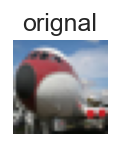

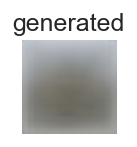

In [ ]:
y_pred=big_model(np.expand_dims(train_tiles[1],axis=0))
y_pred=np.squeeze(y_pred)
y_pred=y_pred*255
fig, m_axs = plt.subplots(1, 1, figsize=(1, 1))
m_axs.imshow(train_recons[1])
m_axs.set_title('orignal')
m_axs.axis('off')
fig, m_axs = plt.subplots(1, 1, figsize=(1, 1))
m_axs.imshow(y_pred.astype('uint8'))
m_axs.set_title('generated')
m_axs.axis('off')

train_tiles[0].shape,train_recons[0].shape,y_pred.shape

In [ ]:
y_pred.min(),y_pred.max()

(94.87038, 206.61757)

In [ ]:
fit_results.history.keys()

dict_keys(['loss', 'mae', 'binary_accuracy', 'val_loss', 'val_mae', 'val_binary_accuracy'])

Text(0.5, 1.0, 'Reconstruction\nAccuracy')

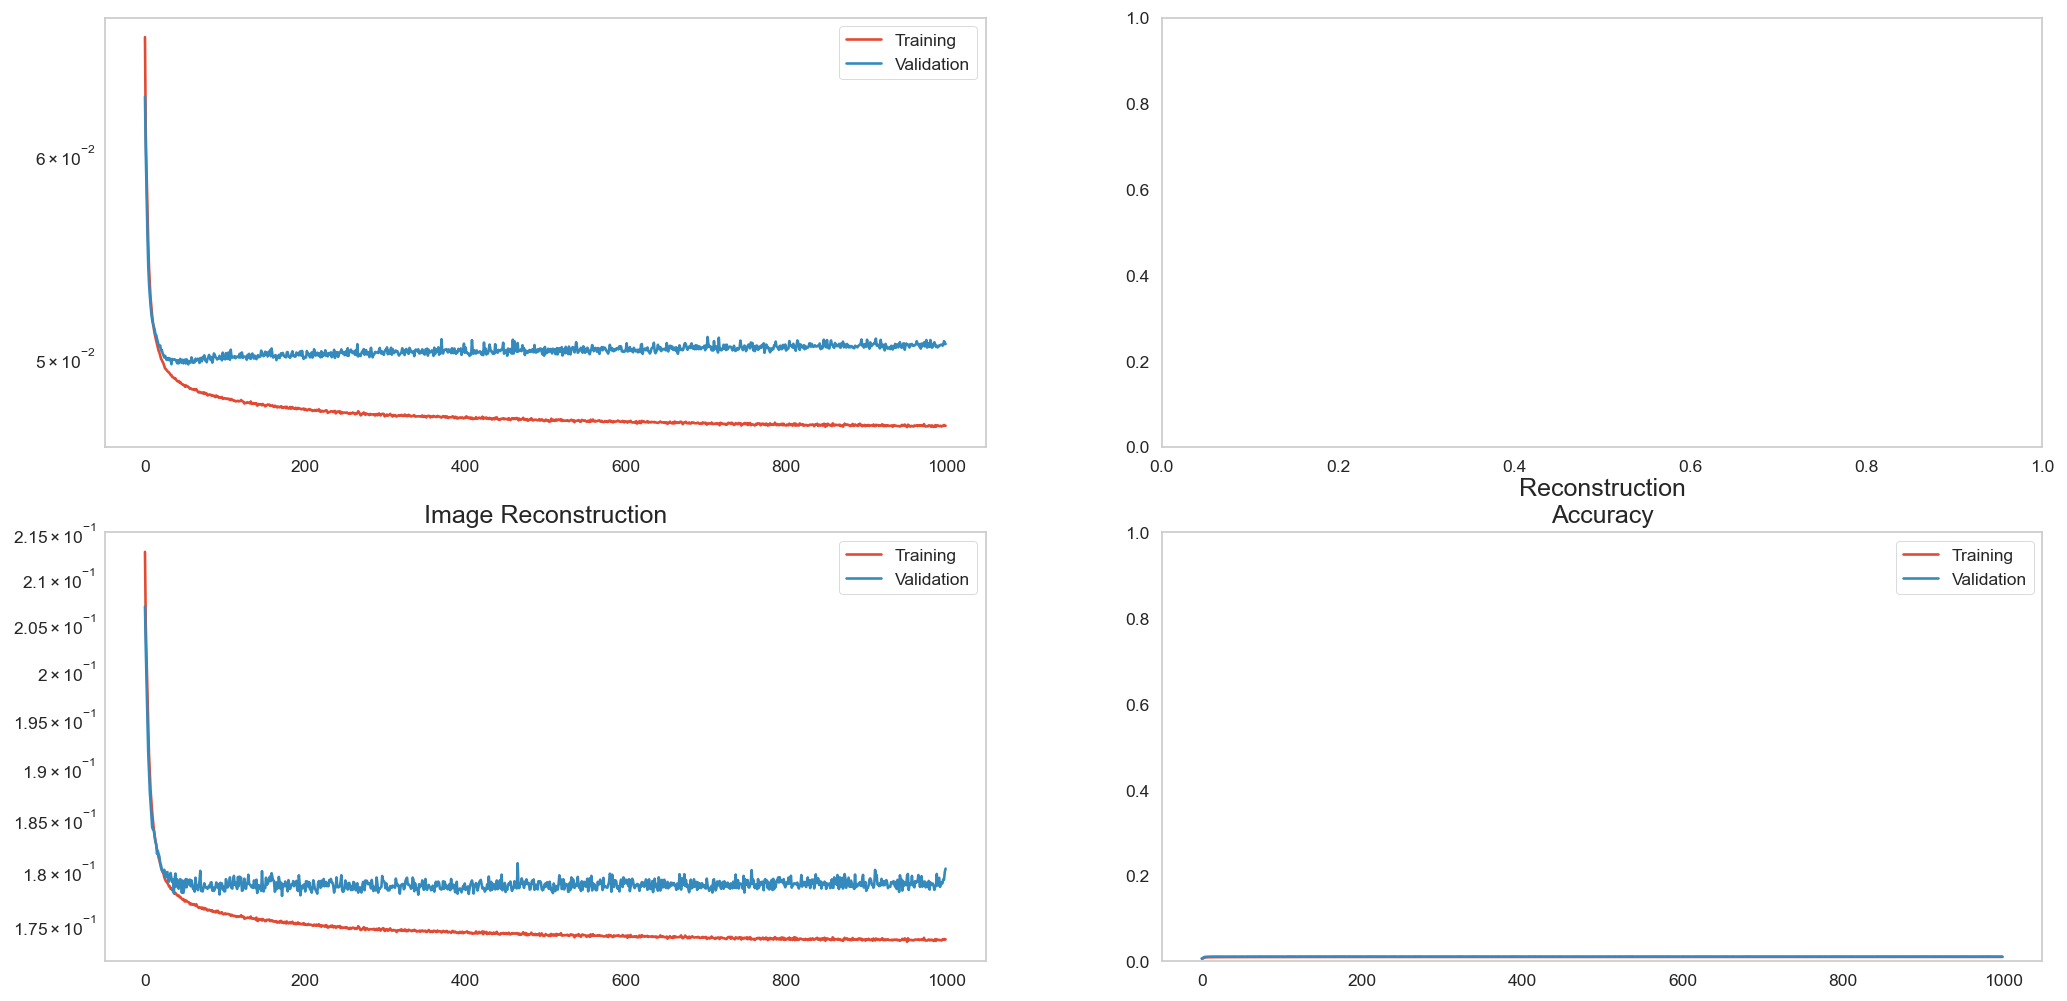

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20, 10))
ax1.semilogy(fit_results.history['loss'], label='Training')
ax1.semilogy(fit_results.history['val_loss'], label='Validation')
ax1.legend()
# ax1.set_title('Loss')
# ax2.plot(fit_results.history['PermutationCategory_sparse_categorical_accuracy'], label='Training')
# ax2.plot(fit_results.history['val_PermutationCategory_sparse_categorical_accuracy'], label='Validation')
# ax2.legend()
# ax2.set_title('Accuracy')
# ax2.set_ylim(0, 1)

ax3.semilogy(fit_results.history['mae'], label='Training')
ax3.semilogy(fit_results.history['val_mae'], label='Validation')
ax3.legend()
ax3.set_title('Image Reconstruction')
      
ax4.plot(fit_results.history['binary_accuracy'], label='Training')
ax4.plot(fit_results.history['val_binary_accuracy'], label='Validation')
ax4.legend()
ax4.set_ylim(0, 1)
ax4.set_title('Reconstruction\nAccuracy')

(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 10, 3)
(1, 9, 10, 10, 3)
[<tf.Tensor 'All_Tile_Input:0' shape=(None, 9, 10, 10, 3) dtype=float32>]
(9, 10, 10, 3)
(9, 10, 1

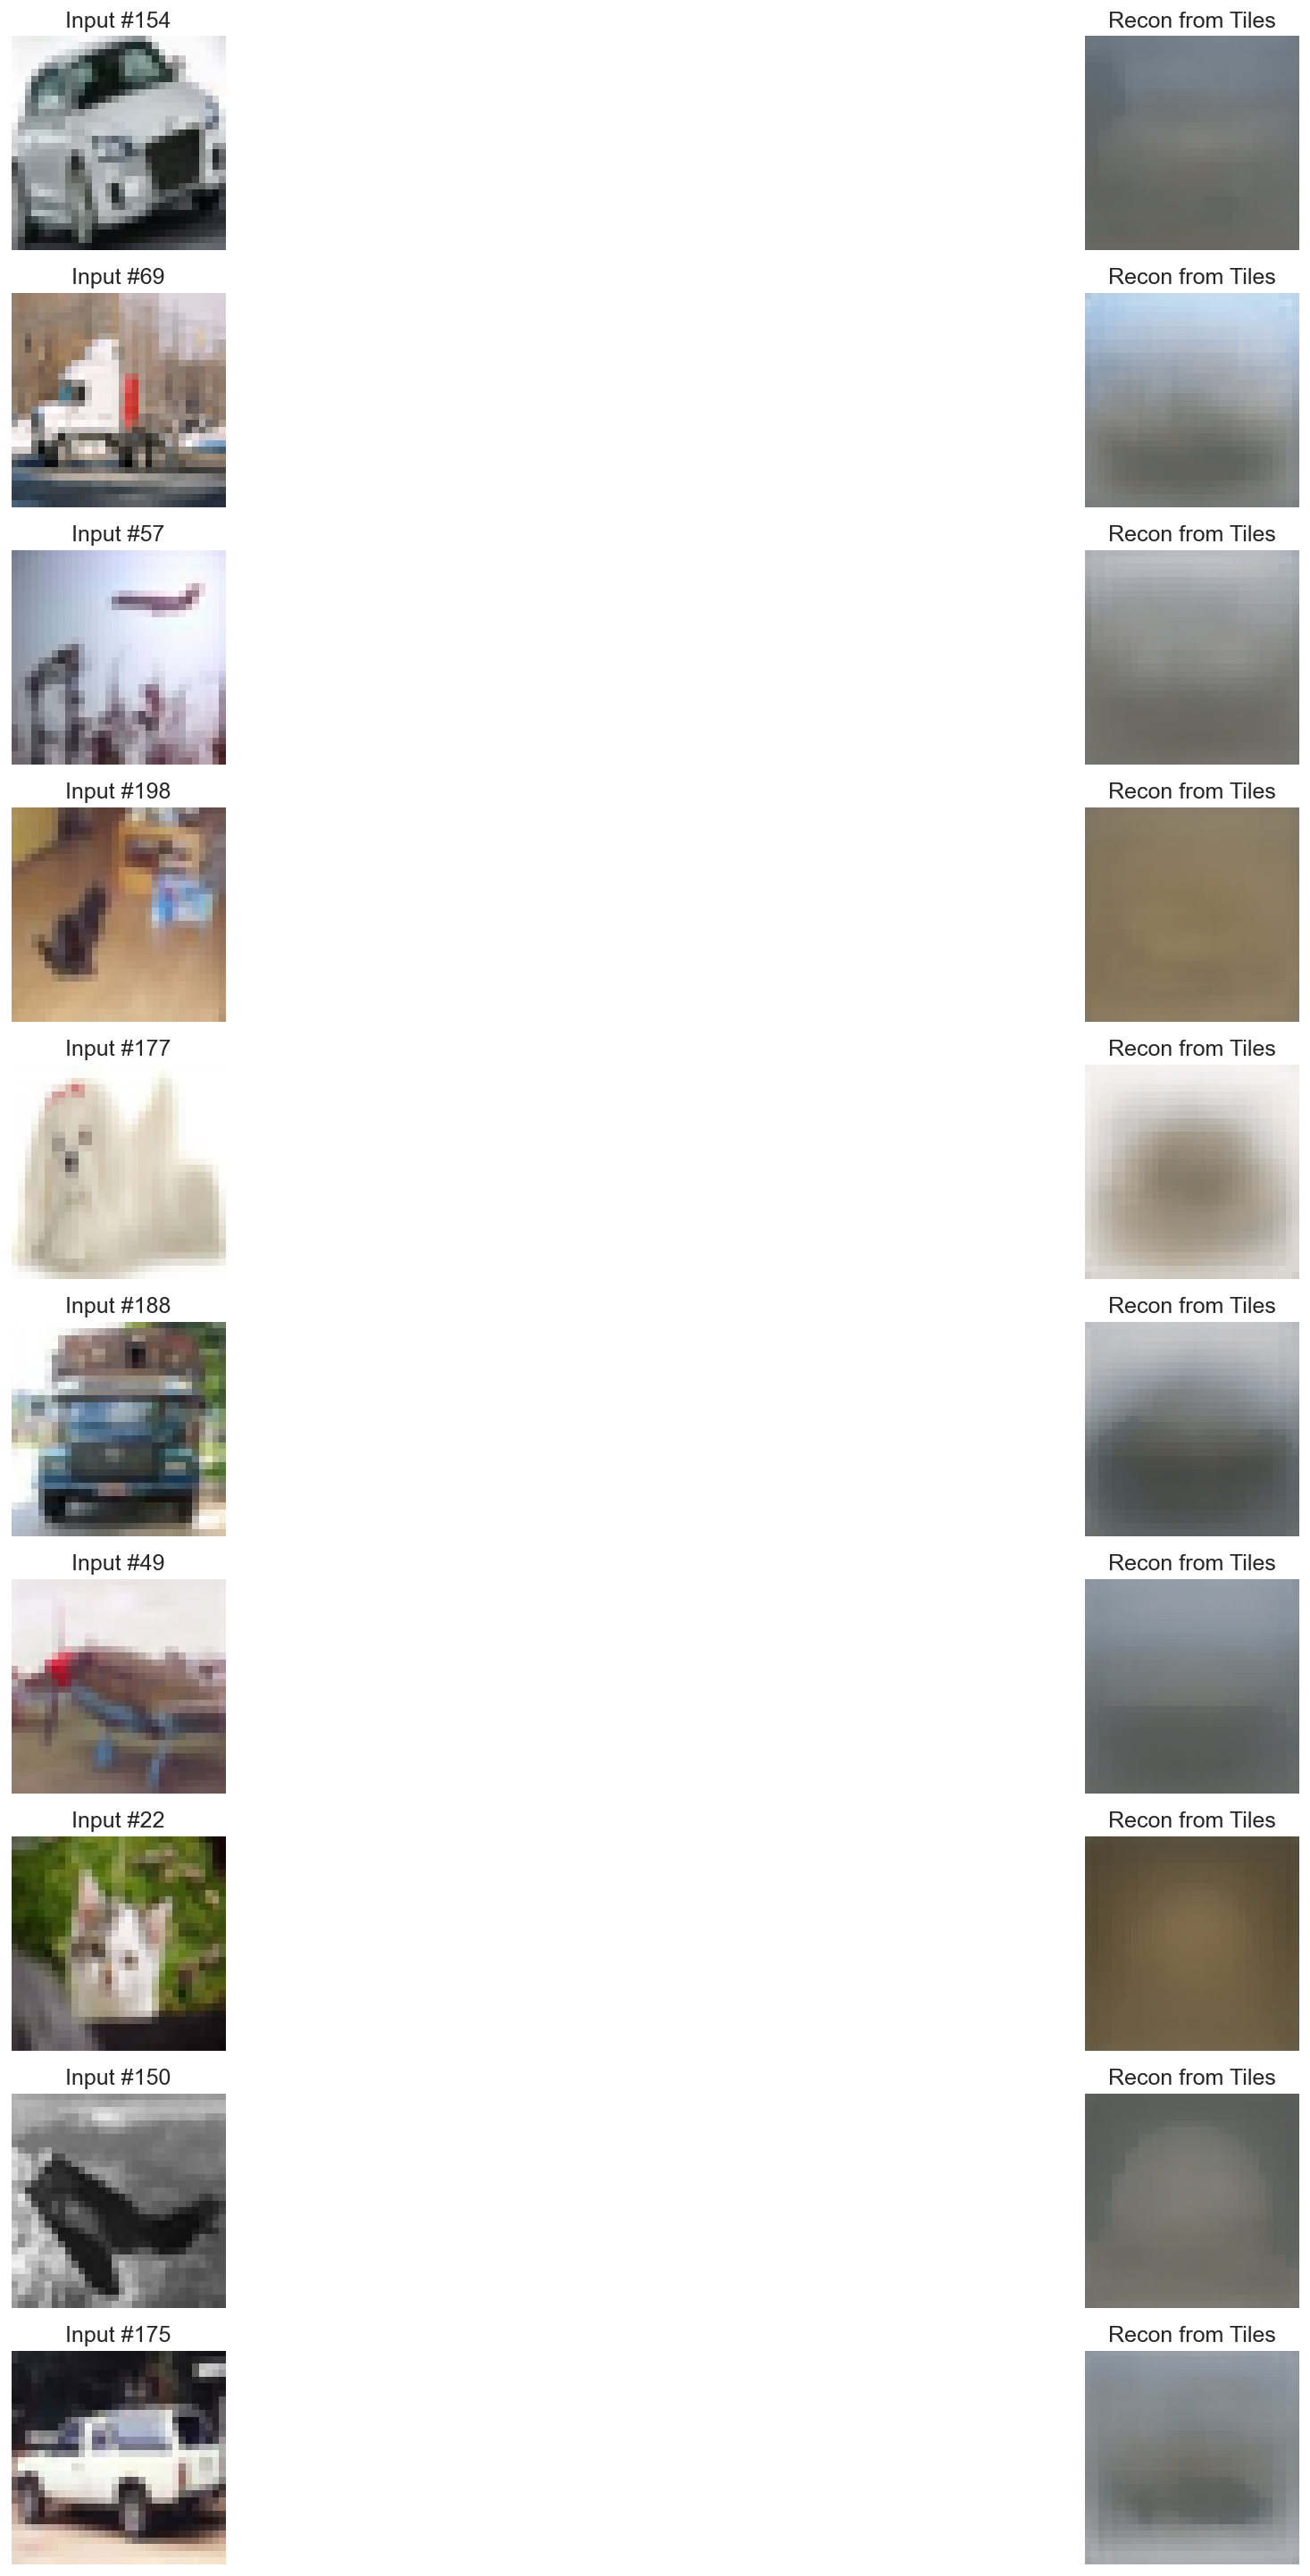

In [ ]:
show_model_output(image_count=10, perm_count=3)

# Downstream Task

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
ix=[]
for i,(x) in enumerate(X_test):
    ix.append(cut_jigsaw(x,10,10))
    clear_output()
    print(i+1,'/',X_test.shape[0])
ix=np.asarray(ix)

10000 / 10000


In [ ]:
from sklearn.model_selection import train_test_split
X_train_, X_test_,ix_train,ix_test, y_train_, y_test_ = train_test_split(X_test,ix, y_test, test_size=0.2)

In [ ]:
class_list=np.unique(y_train_)
n_classes=class_list.shape[0]
n_classes

10

In [ ]:
y_train_d=tf.keras.utils.to_categorical(y_train_, num_classes=n_classes)
y_test_d=tf.keras.utils.to_categorical(y_test_, num_classes=n_classes)

In [ ]:
X_train_.shape, X_test_.shape,ix_train.shape,ix_test.shape, y_train_.shape, y_test_.shape

((8000, 32, 32, 3),
 (2000, 32, 32, 3),
 (8000, 9, 10, 10, 3),
 (2000, 9, 10, 10, 3),
 (8000,),
 (2000,))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
def show_results(x_test_c,y_test_c,class_list,finetune_model,history):    
    Y_pred = finetune_model.predict(x_test_c)
    y_label=np.argmax(y_test_c, axis=1)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_label, y_pred))
    cm = confusion_matrix(y_label, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
    disp.plot()
    plt.show()
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("Accuracy: ",round(sum(ACC)/len(class_list),2))
    print("Sensitivity: ",round(sum(TPR)/len(class_list),2))
    print("Specificity: ",round(sum(TNR)/len(class_list),2))
    print("Precision: ",round(sum(PPV)/len(class_list),2))
    print("Negative predictive value: ",round(sum(NPV)/len(class_list),2))
    print("Fall out: ",round(sum(FPR)/len(class_list),2))
    print("False negative rate: ",round(sum(FNR)/len(class_list),2))
    print("False discovery rate: ",round(sum(FDR)/len(class_list),2))

    # Plot the training and validation loss + accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(epochs, loss,'-r', label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    

# Pre-Text Weighted Model

In [ ]:
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU,MaxPooling2D, UpSampling2D,
    Concatenate)
from tensorflow.keras.models import Sequential, Model


def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        print(layer.name)
        layer.trainable = False

    x = base_model.get_layer("up_sampling2d").output
    #x = AveragePooling2D(pool_size = (4, 4), data_format = 'channels_last')(x)
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    #x = Dense(1024, activation='relu')(x) 
    #x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x) 

    #x = Dense(64, activation = "relu")(x)
    #x = Dropout(0.5)(x)
    #x = Flatten(name = "flatten1")(x)
    #predictions = Dense(3, activation = "softmax")(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024, 1024]
dropout = 0.01

finetune_model = build_finetune_model(big_model, dropout=dropout, fc_layers=FC_LAYERS, num_classes=n_classes)
finetune_model.summary()

All_Tile_Input
Select_0_Tile
Select_1_Tile
Select_2_Tile
Select_3_Tile
Select_4_Tile
Select_5_Tile
Select_6_Tile
Select_7_Tile
Select_8_Tile
TileEncoder
global_average_pooling2d
global_average_pooling2d_1
global_average_pooling2d_2
global_average_pooling2d_3
global_average_pooling2d_4
global_average_pooling2d_5
global_average_pooling2d_6
global_average_pooling2d_7
global_average_pooling2d_8
concatenate
dropout
dense_1
reshape
conv2d_4
up_sampling2d
conv2d_5
batch_normalization_5
leaky_re_lu_4
up_sampling2d_1
conv2d_6
batch_normalization_6
leaky_re_lu_5
ReconImage
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
All_Tile_Input (InputLayer)     [(None, 9, 10, 10, 3 0                                            
__________________________________________________________________________________________________
Select_0_Ti

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 100
BATCH_SIZE = 16
adam = Adam(lr=0.0001)
#finetune_model.load_weights("/content/drive/MyDrive/Anam Code/pascal results/downstream/model_weights_64_0_001.h5")
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
filepath="results/downstream/model_weights_cifar10_TRANSFER.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["accuracy"], verbose=1, mode='max')
callbacks_list = [checkpoint]

In [ ]:
ix_train.shape,y_train_d.shape

((8000, 9, 10, 10, 3), (8000, 10))

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 6.2711 - accuracy: 0.1612
Epoch 00001: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 23ms/step - loss: 6.2711 - accuracy: 0.1612 - val_loss: 4.1081 - val_accuracy: 0.2144
Epoch 2/100
 94/100 [===========================>..] - ETA: 0s - loss: 4.1929 - accuracy: 0.1596
Epoch 00002: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 16ms/step - loss: 4.1891 - accuracy: 0.1562 - val_loss: 3.3630 - val_accuracy: 0.1937
Epoch 3/100
 95/100 [===========================>..] - ETA: 0s - loss: 3.6037 - accuracy: 0.1697
Epoch 00003: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 17ms/step - loss: 3.5623 - accuracy: 0.1700 - val_loss: 3.0819 - val_accuracy: 0.2031
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - lo

 99/100 [============================>.] - ETA: 0s - loss: 2.1057 - accuracy: 0.2393
Epoch 00027: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 18ms/step - loss: 2.1015 - accuracy: 0.2400 - val_loss: 2.0500 - val_accuracy: 0.2519
Epoch 28/100
 98/100 [============================>.] - ETA: 0s - loss: 2.1421 - accuracy: 0.2213
Epoch 00028: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 20ms/step - loss: 2.1374 - accuracy: 0.2225 - val_loss: 2.1177 - val_accuracy: 0.2237
Epoch 29/100
 98/100 [============================>.] - ETA: 0s - loss: 2.1056 - accuracy: 0.2398
Epoch 00029: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 17ms/step - loss: 2.1109 - accuracy: 0.2400 - val_loss: 2.0650 - val_accuracy: 0.2506
Epoch 30/100
 95/100 [===========================>..] - ETA: 0s - loss: 2.099

 99/100 [============================>.] - ETA: 0s - loss: 2.0309 - accuracy: 0.2601
Epoch 00053: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 17ms/step - loss: 2.0313 - accuracy: 0.2587 - val_loss: 2.0378 - val_accuracy: 0.2506
Epoch 54/100
 98/100 [============================>.] - ETA: 0s - loss: 2.0377 - accuracy: 0.2659
Epoch 00054: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 17ms/step - loss: 2.0370 - accuracy: 0.2650 - val_loss: 2.0135 - val_accuracy: 0.2656
Epoch 55/100
 99/100 [============================>.] - ETA: 0s - loss: 2.0092 - accuracy: 0.2626
Epoch 00055: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 16ms/step - loss: 2.0063 - accuracy: 0.2644 - val_loss: 2.0346 - val_accuracy: 0.2581
Epoch 56/100
 98/100 [============================>.] - ETA: 0s - loss: 2.040

 96/100 [===========================>..] - ETA: 0s - loss: 1.9794 - accuracy: 0.2708
Epoch 00079: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 16ms/step - loss: 1.9714 - accuracy: 0.2731 - val_loss: 2.0546 - val_accuracy: 0.2456
Epoch 80/100
 99/100 [============================>.] - ETA: 0s - loss: 1.9909 - accuracy: 0.2740
Epoch 00080: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 15ms/step - loss: 1.9894 - accuracy: 0.2738 - val_loss: 2.0356 - val_accuracy: 0.2406
Epoch 81/100
 96/100 [===========================>..] - ETA: 0s - loss: 1.9776 - accuracy: 0.2760
Epoch 00081: saving model to results/downstream\model_weights_cifar10_TRANSFER.h5
100/100 [==============================] - 2s 16ms/step - loss: 1.9785 - accuracy: 0.2800 - val_loss: 2.0513 - val_accuracy: 0.2569
Epoch 82/100
 97/100 [============================>.] - ETA: 0s - loss: 1.956

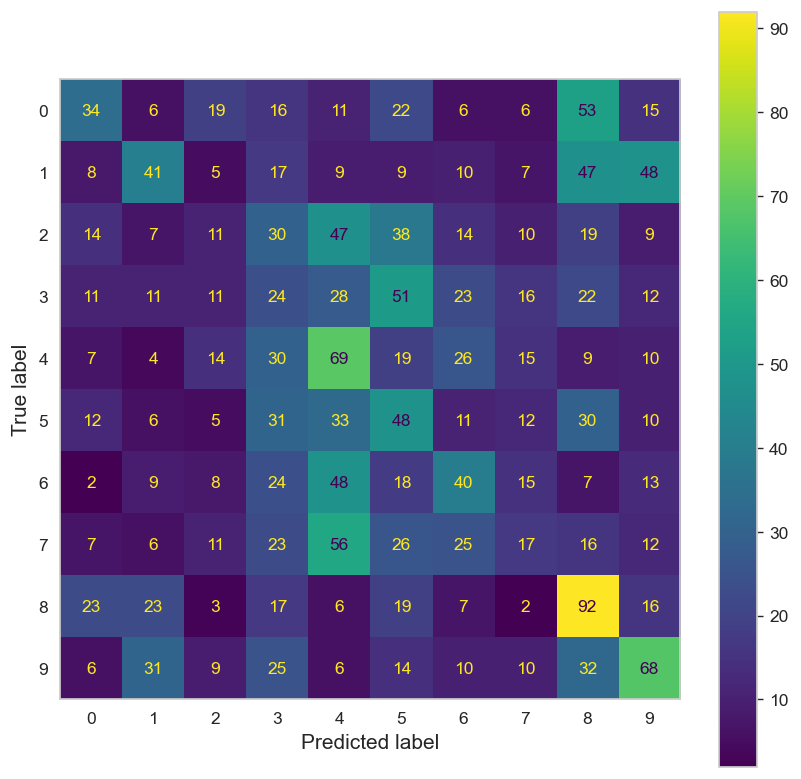

Accuracy:  0.84
Sensitivity:  0.22
Specificity:  0.91
Precision:  0.22
Negative predictive value:  0.91
Fall out:  0.09
False negative rate:  0.78
False discovery rate:  0.78


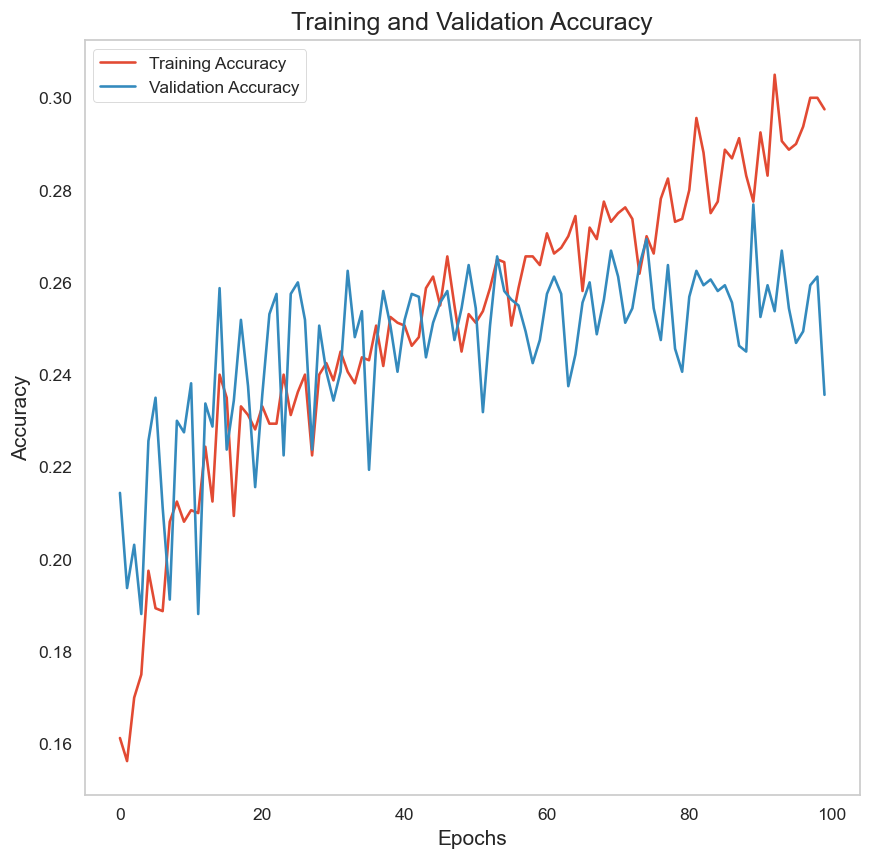

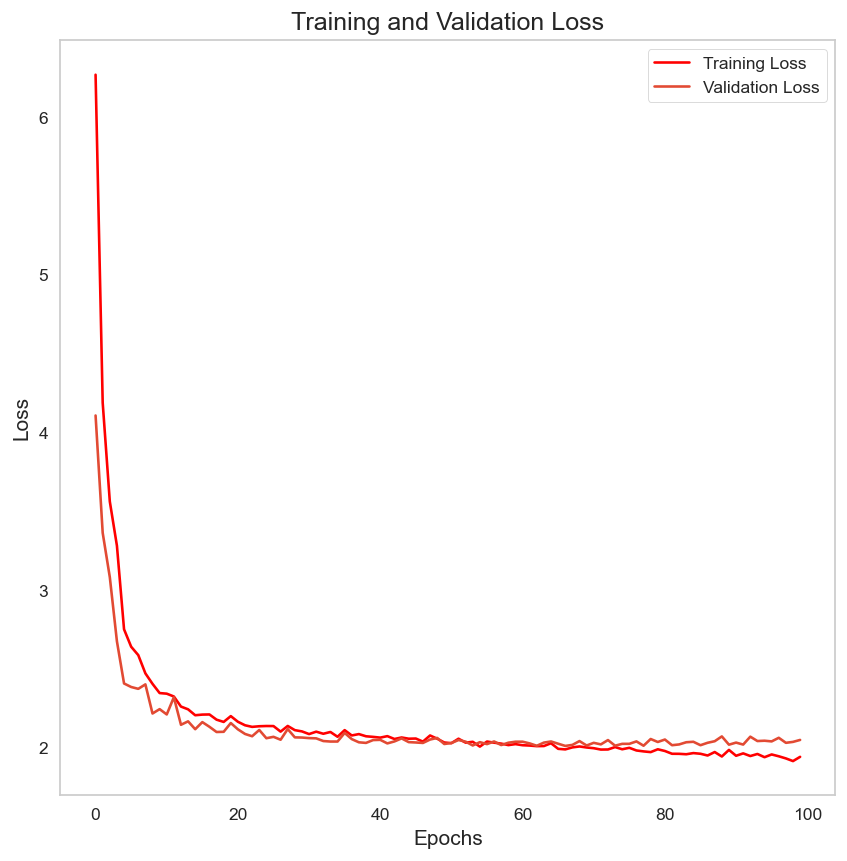

In [ ]:
history_weight = finetune_model.fit(ix_train, y_train_d, epochs=NUM_EPOCHS,workers=8,verbose=1,
                             validation_split = 0.2,
                             steps_per_epoch=(ix_train.shape[0]*0.2)//BATCH_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False, callbacks=callbacks_list)

show_results(ix_test,y_test_d,class_list,finetune_model,history_weight)

# MobileNet

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import MobileNet
HEIGHT = 32
WIDTH = 32
base_model = MobileNet(weights=None, 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    #x = AveragePooling2D(pool_size = (4, 4), data_format = 'channels_last')(x)
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    #x = Dense(1024, activation='relu')(x) 
    #x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x) 

    #x = Dense(64, activation = "relu")(x)
    #x = Dropout(0.5)(x)
    #x = Flatten(name = "flatten1")(x)
    #predictions = Dense(3, activation = "softmax")(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, dropout=dropout, fc_layers=FC_LAYERS, num_classes=len(class_list))
finetune_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)      

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 100
BATCH_SIZE = 16


adam = Adam(lr=0.001)
#finetune_model.load_weights("/content/drive/MyDrive/Anam Code/pascal results/downstream/model_weights_64_0_001.h5")
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
filepath="results/downstream_comp/model_weights_cifar10_BASE.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

Epoch 1/100
 98/100 [============================>.] - ETA: 0s - loss: 2.6118 - accuracy: 0.1244
Epoch 00001: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 24ms/step - loss: 2.6080 - accuracy: 0.1238 - val_loss: 2.3020 - val_accuracy: 0.1037
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 2.3579 - accuracy: 0.1363
Epoch 00002: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 18ms/step - loss: 2.3579 - accuracy: 0.1363 - val_loss: 2.3028 - val_accuracy: 0.1063
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 2.2922 - accuracy: 0.1562
Epoch 00003: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 18ms/step - loss: 2.2922 - accuracy: 0.1562 - val_loss: 2.3038 - val_accuracy: 0.0962
Epoch 4/100
100/100 [==============================] - ETA: 0s -

 98/100 [============================>.] - ETA: 0s - loss: 1.9743 - accuracy: 0.2315
Epoch 00027: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 18ms/step - loss: 1.9721 - accuracy: 0.2313 - val_loss: 2.0820 - val_accuracy: 0.1794
Epoch 28/100
 97/100 [============================>.] - ETA: 0s - loss: 1.9823 - accuracy: 0.2384
Epoch 00028: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 17ms/step - loss: 1.9809 - accuracy: 0.2387 - val_loss: 1.9278 - val_accuracy: 0.2562
Epoch 29/100
 97/100 [============================>.] - ETA: 0s - loss: 1.9592 - accuracy: 0.2416
Epoch 00029: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 17ms/step - loss: 1.9584 - accuracy: 0.2412 - val_loss: 2.1078 - val_accuracy: 0.2144
Epoch 30/100
 96/100 [===========================>..] - ETA: 0s - loss: 2.

100/100 [==============================] - ETA: 0s - loss: 2.0017 - accuracy: 0.2106
Epoch 00053: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 23ms/step - loss: 2.0017 - accuracy: 0.2106 - val_loss: 2.2081 - val_accuracy: 0.2031
Epoch 54/100
 97/100 [============================>.] - ETA: 0s - loss: 2.0601 - accuracy: 0.2365
Epoch 00054: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 22ms/step - loss: 2.0564 - accuracy: 0.2362 - val_loss: 2.0953 - val_accuracy: 0.2463
Epoch 55/100
 99/100 [============================>.] - ETA: 0s - loss: 1.9506 - accuracy: 0.2519
Epoch 00055: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 23ms/step - loss: 1.9473 - accuracy: 0.2544 - val_loss: 1.9311 - val_accuracy: 0.2944
Epoch 56/100
 98/100 [============================>.] - ETA: 0s - loss: 1.

 97/100 [============================>.] - ETA: 0s - loss: 1.7736 - accuracy: 0.3099
Epoch 00079: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 16ms/step - loss: 1.7700 - accuracy: 0.3100 - val_loss: 2.0772 - val_accuracy: 0.2269
Epoch 80/100
 96/100 [===========================>..] - ETA: 0s - loss: 1.8382 - accuracy: 0.2819
Epoch 00080: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 17ms/step - loss: 1.8356 - accuracy: 0.2812 - val_loss: 1.8211 - val_accuracy: 0.3081
Epoch 81/100
 99/100 [============================>.] - ETA: 0s - loss: 1.8057 - accuracy: 0.3100
Epoch 00081: saving model to results/downstream_comp\model_weights_cifar10_BASE.h5
100/100 [==============================] - 2s 18ms/step - loss: 1.8021 - accuracy: 0.3113 - val_loss: 1.7981 - val_accuracy: 0.3131
Epoch 82/100
 96/100 [===========================>..] - ETA: 0s - loss: 1.

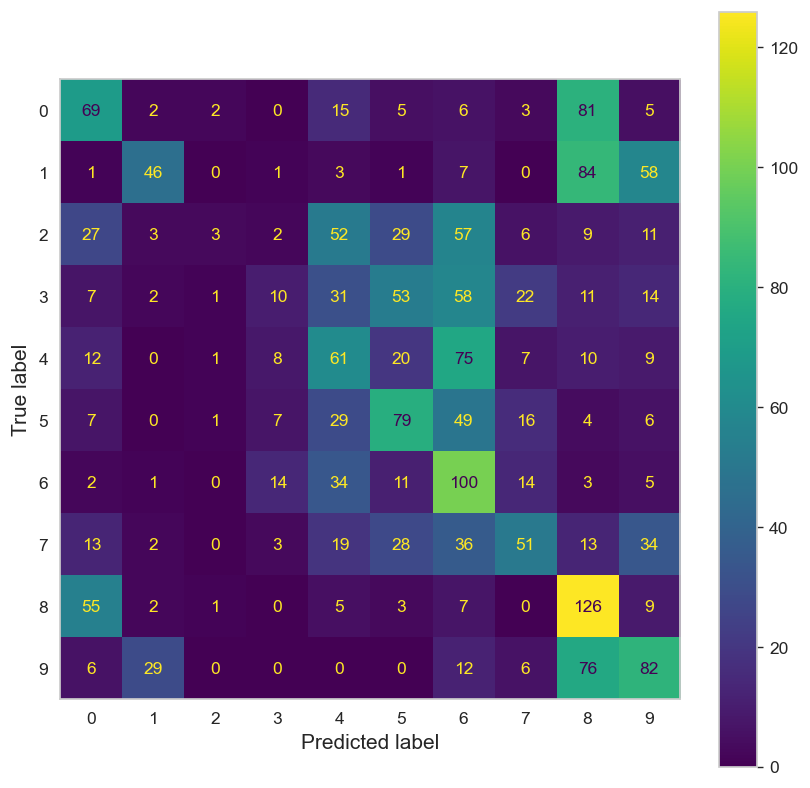

Accuracy:  0.86
Sensitivity:  0.32
Specificity:  0.92
Precision:  0.33
Negative predictive value:  0.92
Fall out:  0.08
False negative rate:  0.68
False discovery rate:  0.67


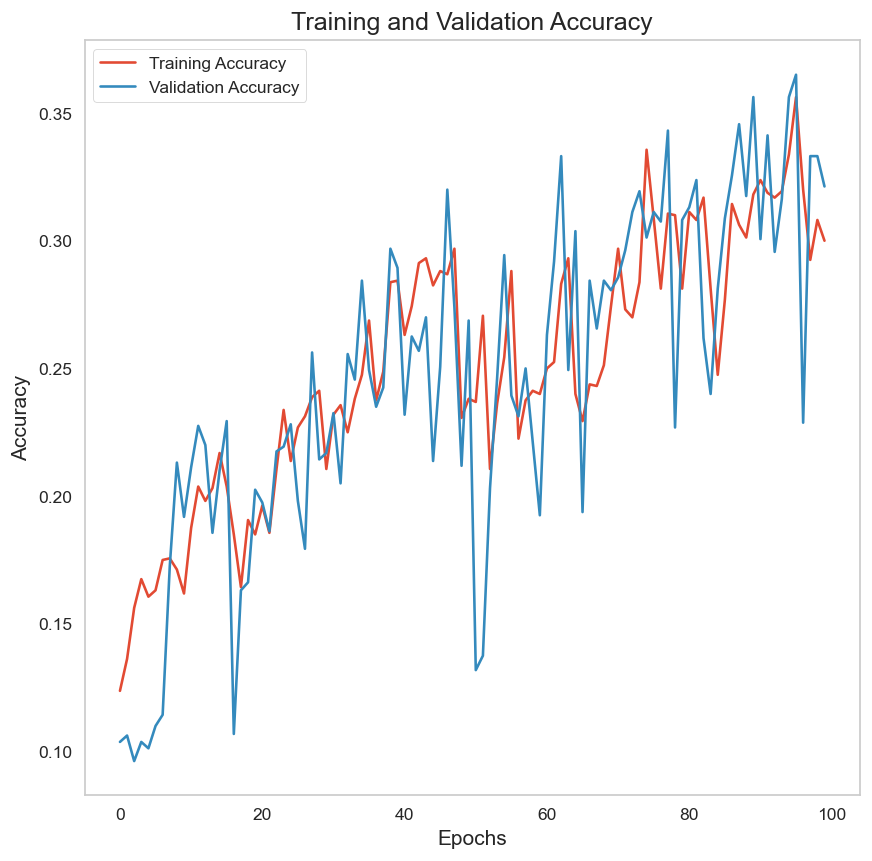

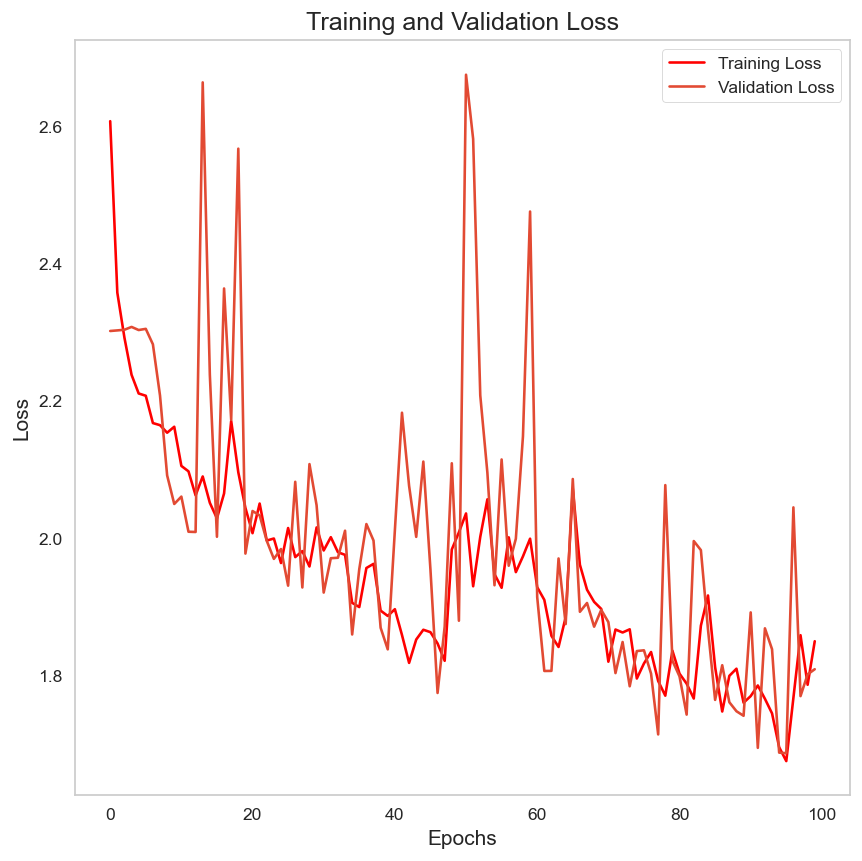

In [ ]:
history_base = finetune_model.fit(X_train_, y_train_d, epochs=NUM_EPOCHS, workers=8, validation_split = 0.2,
                             steps_per_epoch=(X_train_.shape[0]*0.2)//BATCH_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False, callbacks=callbacks_list)

show_results(X_test_,y_test_d,class_list,finetune_model,history_base)

In [ ]:
def compare_results(history_weighted, history_baseline):    
    
    
    # Plot the training and validation loss + accuracy
    acc_b = history_baseline.history['accuracy']
    acc_w = history_weighted.history['accuracy']
    epochs = range(len(acc_w))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc_b,color='green', label='From Baseline (MobileNet)')
    plt.plot(epochs, acc_w,color='blue', label='From Permutation weights')
    plt.legend()
    plt.title('Training Accuracy')
    plt.show()


    loss_b = history_baseline.history['loss']
    loss_w = history_weighted.history['loss']
    epochs = range(len(acc_w))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(epochs, loss_b,color='green', label='From Baseline (MobileNet)')
    plt.plot(epochs, loss_w,color='blue', label='From Permutation weights')
    plt.legend()
    plt.title('Training Loss')
    plt.show()
    

# Comparison Graphs

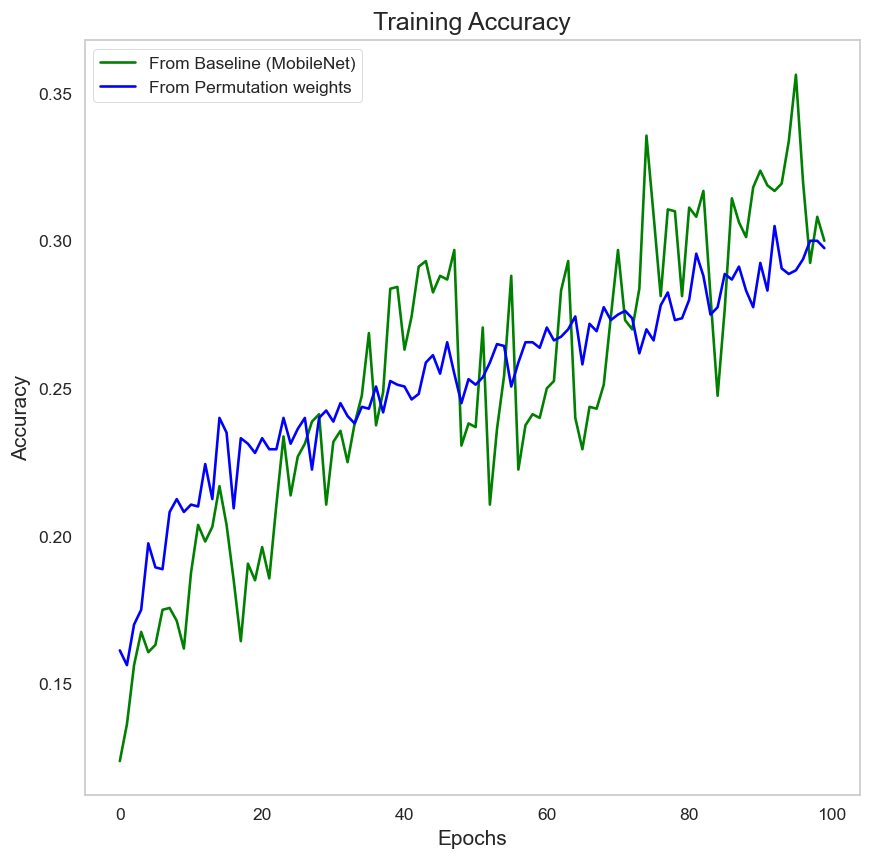

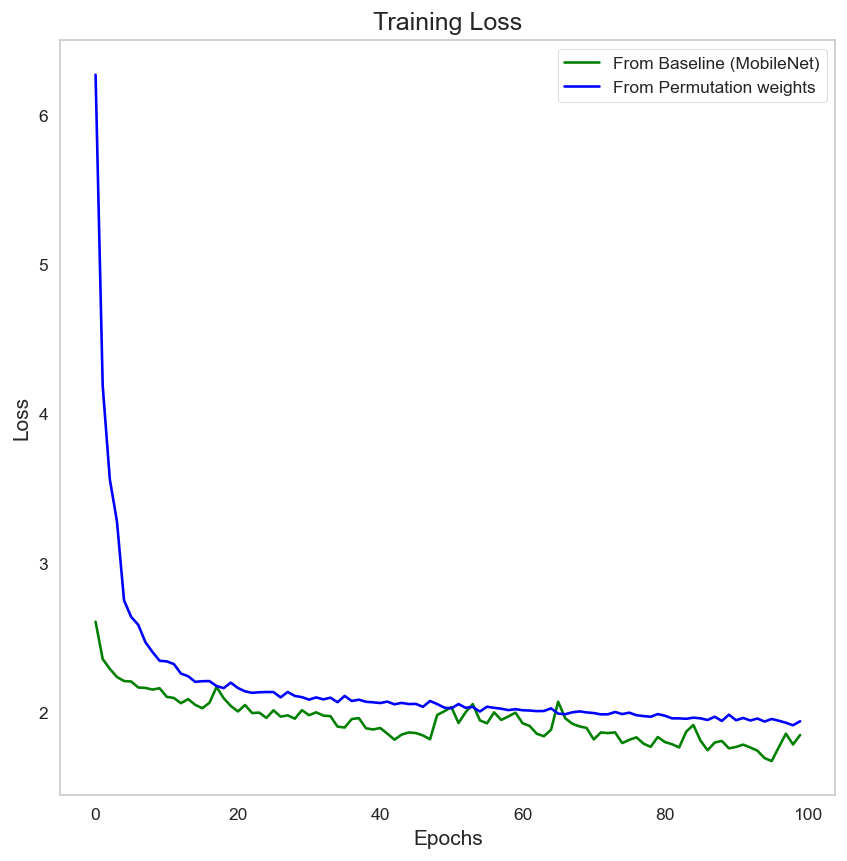

In [ ]:
compare_results(history_weight,history_base)

# *THE END*